## Fit autocovariance

Objective : Estimate tides paramters by fitting a model to Eulerian and Lagrangian binned covariance of the demodulated velocity field

Several parameters of the fitting method can be testing.
Here we focus on a least-square method.

1) Basic method :

Model : $\tilde V e^{-\tau/\tilde T}cos(\omega\tau)$ ; with $\tilde V$ the variance, $\tilde T$ the incoherence timescale and $\omega = \frac{\omega_{S2}-\omega_{M2}}{2}$ fixed the spring neap cycle frequency over 2 (oscilations caused by demodulation)

No bounds, no first guess for the estimates, same weight at all timelag

2) Bounds imposed

3) More weight on the shortest timelags (20days) and a lot on the first. First guess for $\tilde V$ fixed at the autocovariance at timelag 0

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [2]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [3]:
omega_sn = (omega_S2-omega_M2)/2

print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [4]:
def y_fit(tau,T,V):
    return V*np.exp(-tau/T)*np.cos(rad*omega_sn*tau)
def yfit_mixed(tau,T,V,Vinc):
    return V*(1+0.5*np.exp(-tau/T))*np.cos(rad*omega_sn*tau)

def y_fit_ri(tau,T,V):
    return V*np.exp(-tau/T)*np.sin(rad*omega_sn*tau)

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bins',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,**kwargs,
           cbar_kwargs={'fraction':0.02})
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [6]:
#root_path = '/home/datawork-lops-osi/equinox/jetn/'
root_path = '/Users/zcaspar/codes/mit4320/'
#low :
file_E = root_path +'Ecov_SSU_low_mean0_dl2.nc'
file_L = root_path +'Lcov_SSU_low_mean0_dl2.nc'

dsE_low = xr.open_dataset(file_E)
dsL_low = xr.open_dataset(file_L)
low_dl2 = xr.open_dataset(root_path+'energy_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}) # Energy, 2°bins
low_var_dl2 = xr.open_dataset(root_path+'variance_SSU_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}) # Energy, 2°bins

#tide
file_E = root_path +'binned_Ecov_uu_dl2.nc'
file_L = root_path +'binned_Lcov_uu_dl2_flag10.nc'
file_L_T80 = root_path +'binned_Lcov_uu_dl2_flag10_T80.nc'
file_E_T80 = root_path +'Ecov_SSU_T80_dl2.nc'

dsE = xr.open_dataset(file_E)
dsL = xr.open_dataset(file_L)
dsE_SSV = xr.open_dataset(root_path +'binned_Ecov_vv_dl2.nc')
dsL_SSV = xr.open_dataset(root_path +'binned_Lcov_vv_dl2_flag10.nc')

dsL_80 = xr.open_dataset(file_L_T80)
dsE_80 = xr.open_dataset(file_E_T80)

hf_dl1 = xr.merge([xr.open_dataset(root_path+'energy_%s_binned_dl1.0.nc'% i).rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}
                                                                                   ) for i in ['SSU','SSV']])
hf_dl2 = xr.open_dataset(root_path+'energy_SSU_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'})
# Tidal variance, 2°bins

dsE_Eta = xr.open_dataset(root_path+'Ecov_Eta_dl2.nc')


#path = '/Users/zcaspar/codes/Diagnostics/'+run#local


In [7]:
dsE = xr.merge([dsE.rename({'rr':'rr_SSU','ri':'ri_SSU'}),
                dsE_SSV.rename({'rr':'rr_SSV','ri':'ri_SSV'})])

dsL = xr.merge([dsL.rename({'rr':'rr_SSU','ri':'ri_SSU'}),
                dsL_SSV.rename({'rr':'rr_SSV','ri':'ri_SSV'})])
dsL

<xarray.Dataset>
Dimensions:   (lat_bins: 59, lon_bins: 179, lags: 961)
Coordinates:
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lags      (lags) float64 0.0 0.04167 0.08333 0.125 ... 39.92 39.96 40.0
Data variables:
    rr_SSU    (lat_bins, lon_bins, lags) float64 ...
    ri_SSU    (lat_bins, lon_bins, lags) float64 ...
    count     (lat_bins, lon_bins) float64 0.0 1.0 0.0 0.0 ... 14.0 11.0 14.0
    rr_SSV    (lat_bins, lon_bins, lags) float64 ...
    ri_SSV    (lat_bins, lon_bins, lags) float64 ...

### Visualization variance

Text(0.5, 1.0, 'Lagrangian variance, SSU')

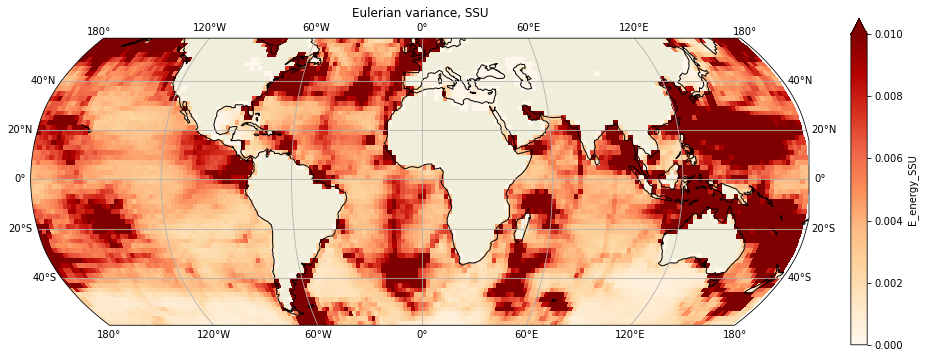

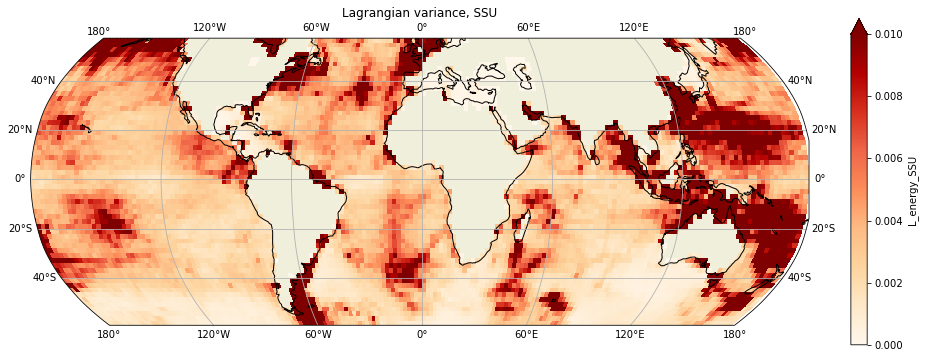

In [14]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(hf_dl2.E_energy_SSU,colmap='OrRd',vlim=(0,0.01))
ax.set_title('Eulerian variance, SSU')
fig = plt.figure(figsize=(15,6))


fig,ax = plot_maps(hf_dl2.L_energy_SSU,colmap='OrRd',vlim=(0,0.01))
ax.set_title('Lagrangian variance, SSU')

Text(0.5, 1.0, 'Lagrangian variance')

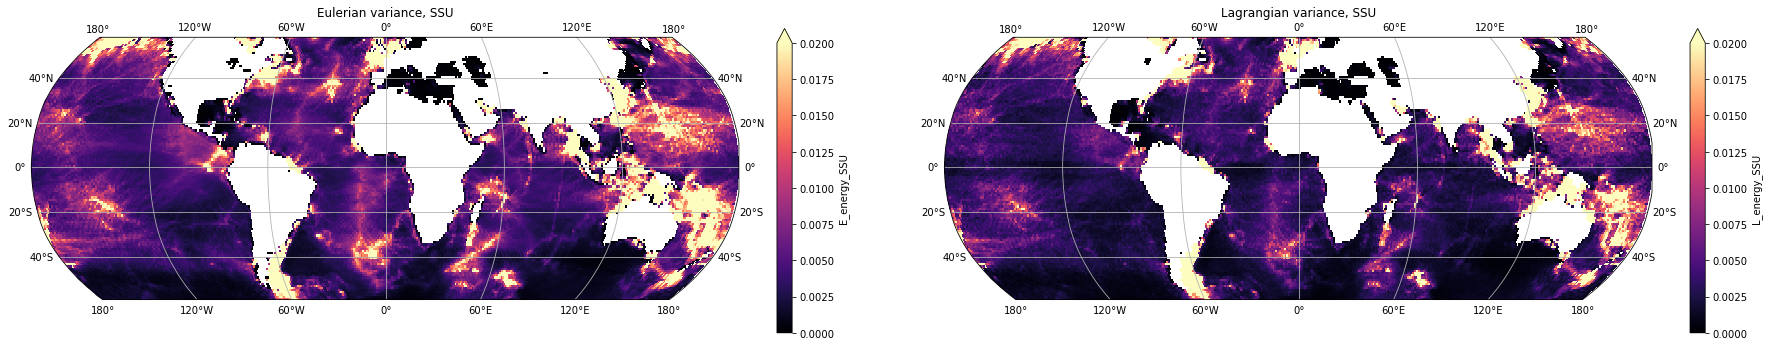

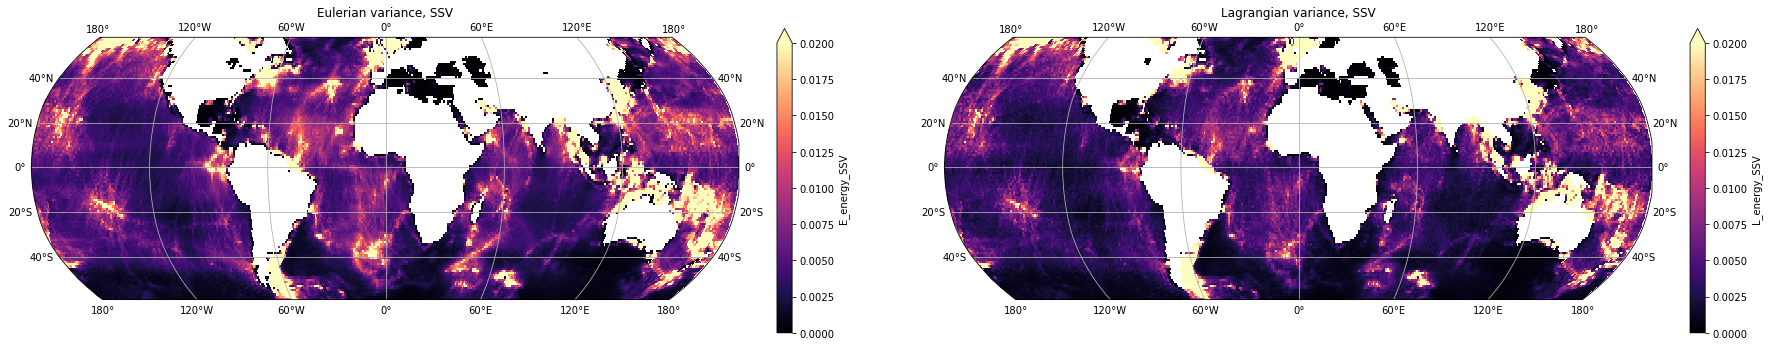

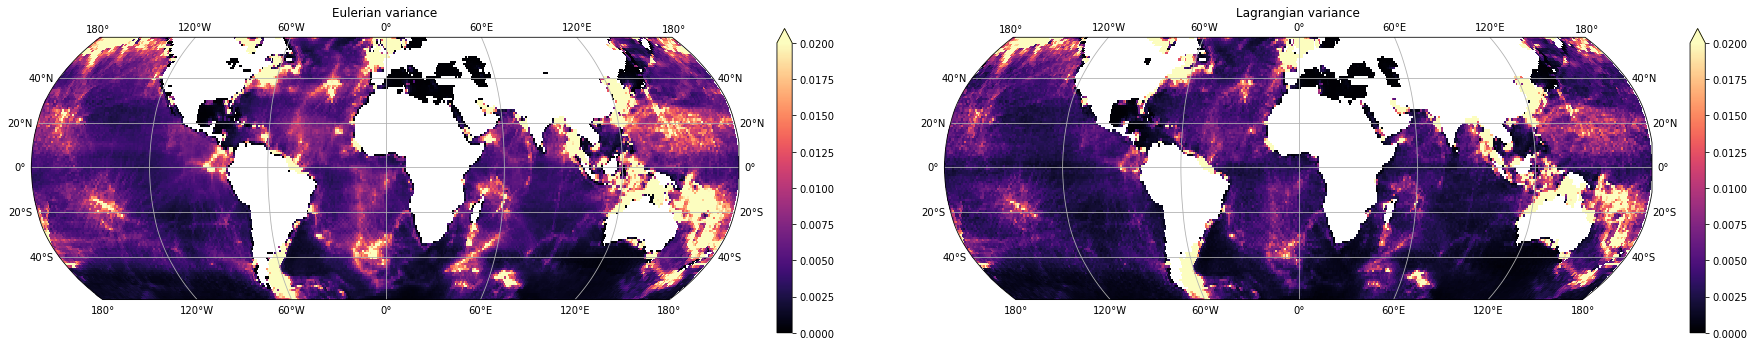

In [10]:
fig = plt.figure(figsize=(30,15))
fig,ax = plot_maps(hf_dl1.E_energy_SSU,colmap='magma',vlim=(0,0.02),axes=121)
ax.set_title('Eulerian variance, SSU')
fig,ax = plot_maps(hf_dl1.L_energy_SSU,colmap='magma',vlim=(0,0.02),axes=122)
ax.set_title('Lagrangian variance, SSU')

fig = plt.figure(figsize=(30,15))
fig,ax = plot_maps(hf_dl1.E_energy_SSV,colmap='magma',vlim=(0,0.02),axes=121)
ax.set_title('Eulerian variance, SSV')
fig,ax = plot_maps(hf_dl1.L_energy_SSV,colmap='magma',vlim=(0,0.02),axes=122)
ax.set_title('Lagrangian variance, SSV')

fig = plt.figure(figsize=(30,15))
fig,ax = plot_maps(0.5*(hf_dl1.E_energy_SSU+hf_dl1.E_energy_SSV),colmap='magma',vlim=(0,0.02),axes=121)
ax.set_title('Eulerian variance')
fig,ax = plot_maps(0.5*(hf_dl1.L_energy_SSU+hf_dl1.L_energy_SSV),colmap='magma',vlim=(0,0.02),axes=122)
ax.set_title('Lagrangian variance')

Text(0.5, 1.0, 'Variance ratio')

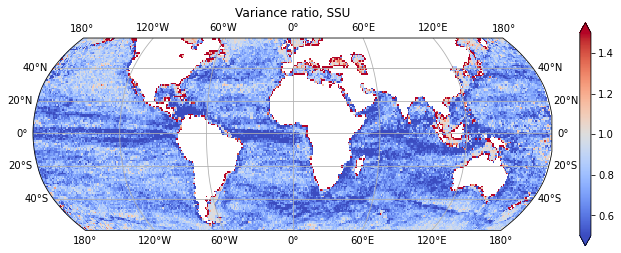

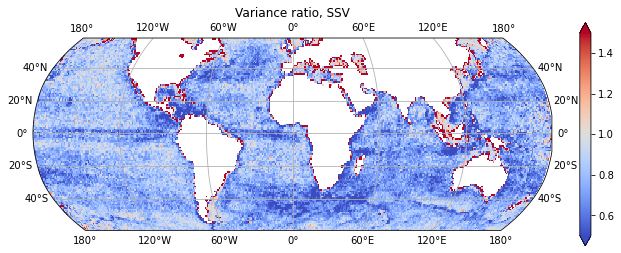

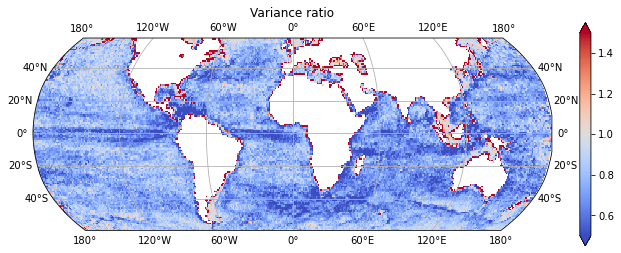

In [11]:
fig = plt.figure(figsize=(10,10))
fig,ax = plot_maps(hf_dl1.L_energy_SSU/hf_dl1.E_energy_SSU,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Variance ratio, SSU')

fig = plt.figure(figsize=(10,10))
fig,ax = plot_maps(hf_dl1.L_energy_SSV/hf_dl1.E_energy_SSV,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Variance ratio, SSV')

fig = plt.figure(figsize=(10,10))
fig,ax = plot_maps((hf_dl1.L_energy_SSU+hf_dl1.L_energy_SSV)/(hf_dl1.E_energy_SSU+hf_dl1.E_energy_SSV),colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Variance ratio')

In [9]:
dsE = dsE.where(dsE.rr_SSU.isel(lags=0)>0)
#dsE_SSV = dsE_SSV.where(dsE_SSV.rr_SSV.isel(lags=0)>0)

Text(0.5, 1.0, 'Lagrangian variance')

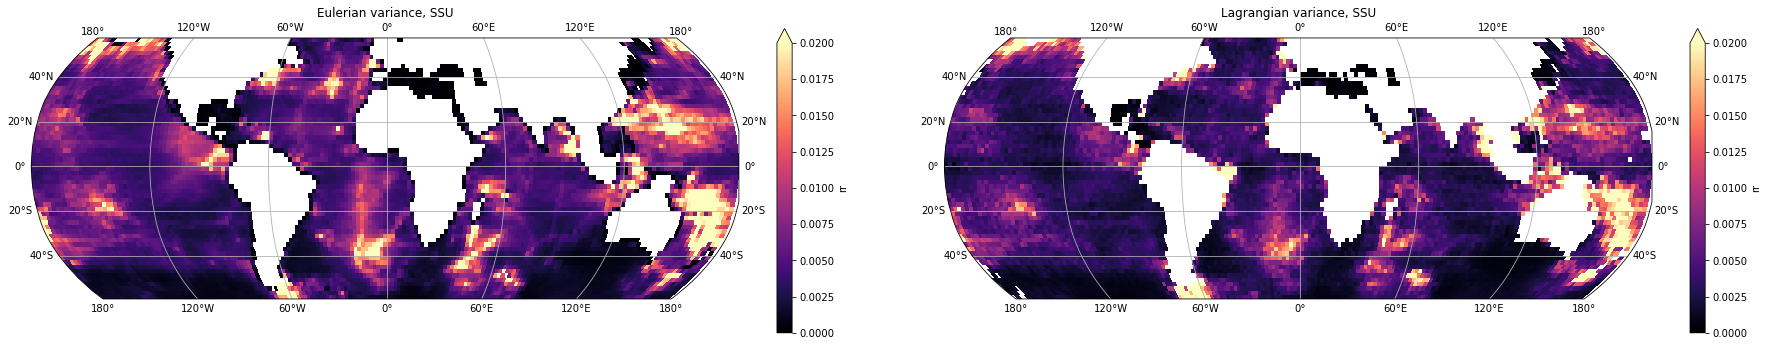

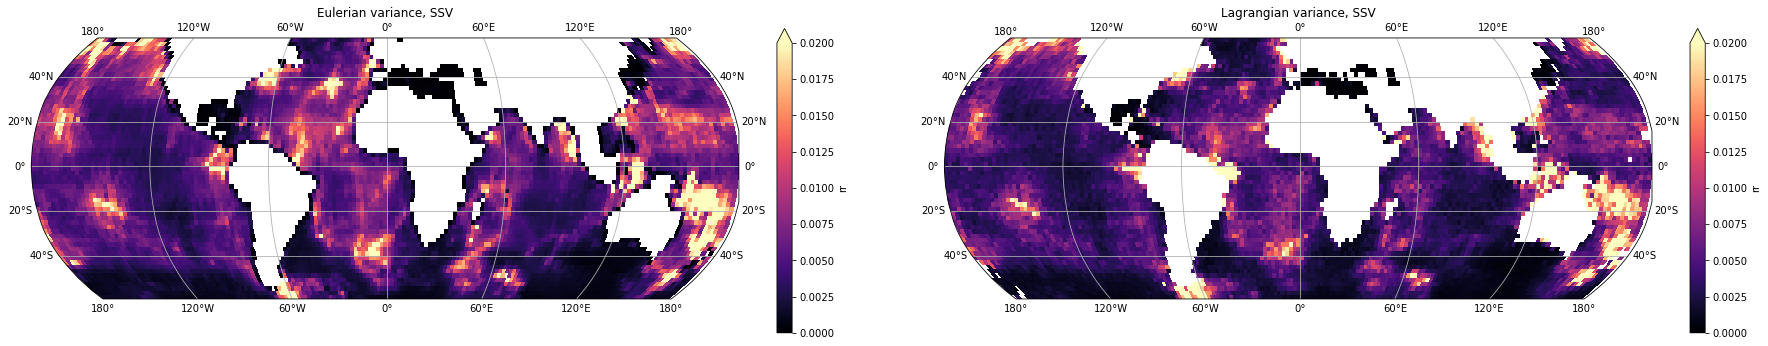

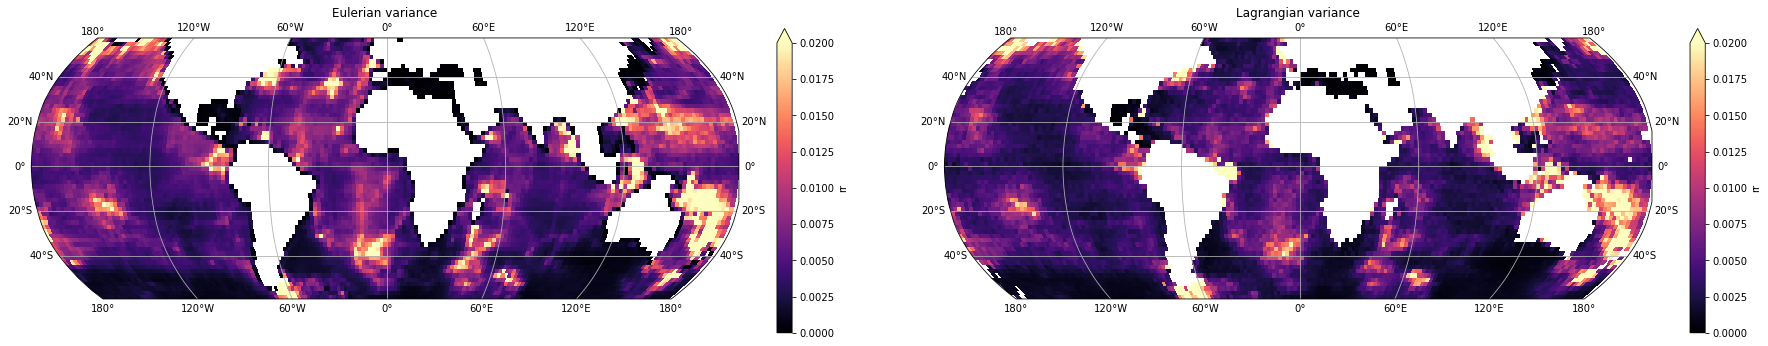

In [13]:
fig = plt.figure(figsize=(30,15))
fig,ax = plot_maps(2*dsE.rr.isel(lags=0),colmap='magma',vlim=(0,0.02),axes=121)
ax.set_title('Eulerian variance, SSU')
fig,ax = plot_maps(2*dsL.rr.isel(lags=0),colmap='magma',vlim=(0,0.02),axes=122)
ax.set_title('Lagrangian variance, SSU')

fig = plt.figure(figsize=(30,15))
fig,ax = plot_maps(2*dsE_SSV.rr.isel(lags=0),colmap='magma',vlim=(0,0.02),axes=121)
ax.set_title('Eulerian variance, SSV')
fig,ax = plot_maps(2*dsL_SSV.rr.isel(lags=0),colmap='magma',vlim=(0,0.02),axes=122)
ax.set_title('Lagrangian variance, SSV')

fig = plt.figure(figsize=(30,15))
fig,ax = plot_maps(dsE.rr.isel(lags=0)+dsE_SSV.rr.isel(lags=0),colmap='magma',vlim=(0,0.02),axes=121)
ax.set_title('Eulerian variance')
fig,ax = plot_maps(dsL.rr.isel(lags=0)+dsL_SSV.rr.isel(lags=0),colmap='magma',vlim=(0,0.02),axes=122)
ax.set_title('Lagrangian variance')

Text(0.5, 1.0, 'Variance ratio')

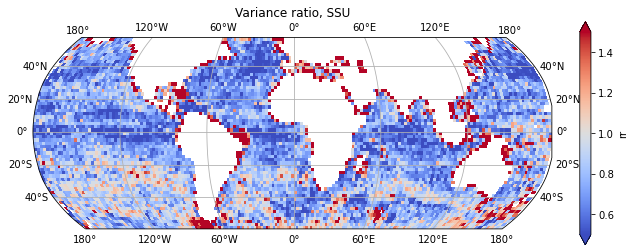

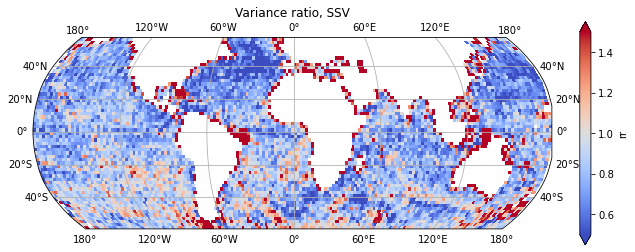

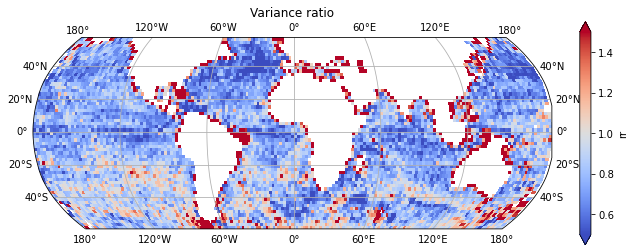

In [14]:
fig = plt.figure(figsize=(10,10))
fig,ax = plot_maps(dsL.rr.isel(lags=0)/dsE.rr.isel(lags=0),colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Variance ratio, SSU')

fig = plt.figure(figsize=(10,10))
fig,ax = plot_maps(dsL_SSV.rr.isel(lags=0)/dsE_SSV.rr.isel(lags=0),colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Variance ratio, SSV')

fig = plt.figure(figsize=(10,10))
fig,ax = plot_maps((dsL.rr.isel(lags=0)+dsL_SSV.rr.isel(lags=0))/(dsE.rr.isel(lags=0)+dsE_SSV.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Variance ratio')

Text(0.5, 1.0, 'Eulerian ratio autocovariance/demodulation')

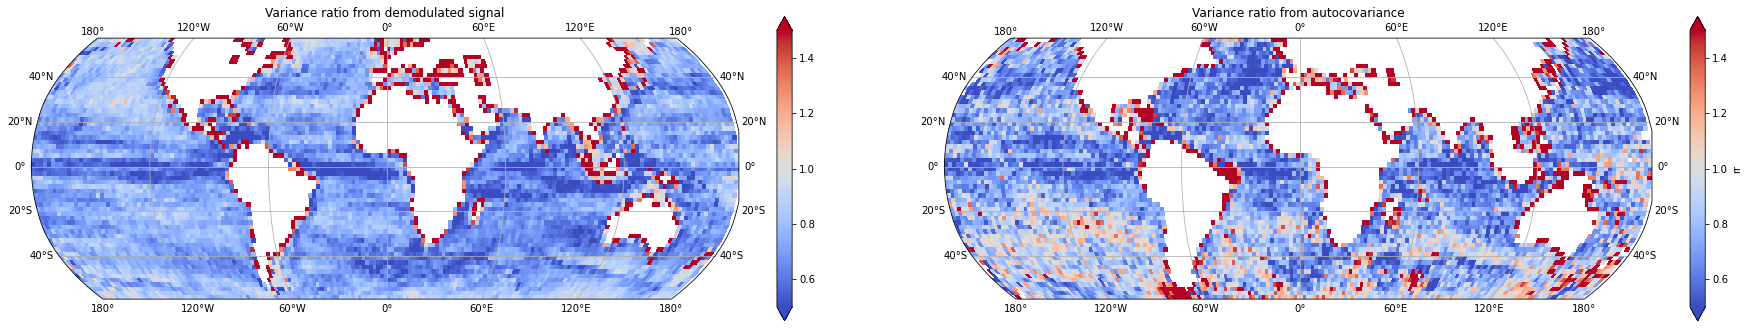

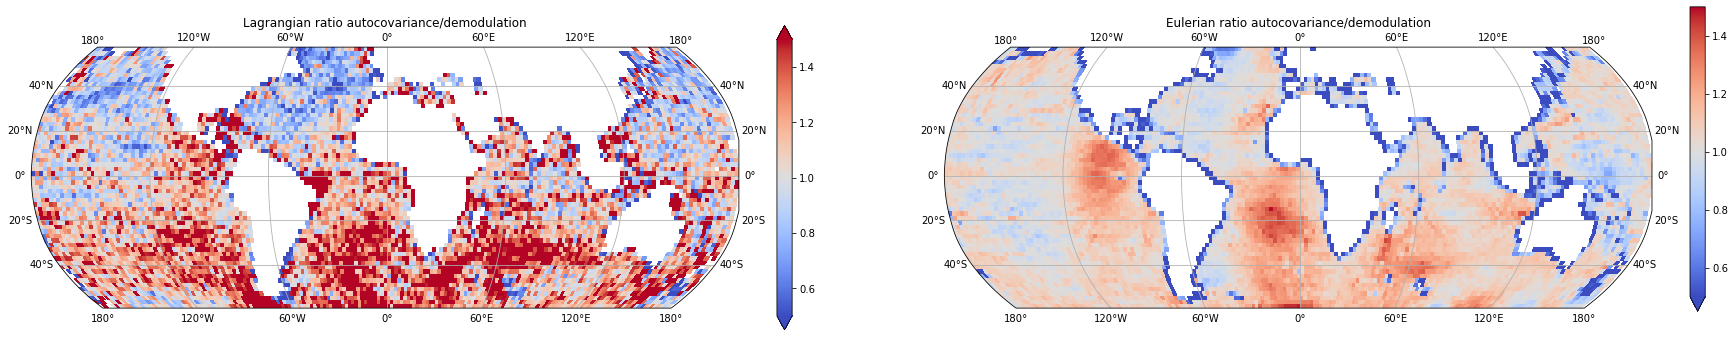

In [15]:
fig = plt.figure(figsize=(30,20))
fig,ax = plot_maps(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0.5,1.5),axes=121)
ax.set_title('Variance ratio from demodulated signal')
fig,ax = plot_maps(dsL.rr.isel(lags=0)/dsE.rr.isel(lags=0),colmap='coolwarm',vlim=(0.5,1.5),axes=122)
ax.set_title('Variance ratio from autocovariance')

fig = plt.figure(figsize=(30,20))
fig,ax = plot_maps(2*dsL.rr.isel(lags=0)/hf_dl2.L_energy_SSU,colmap='coolwarm',vlim=(0.5,1.5),axes=121)
ax.set_title('Lagrangian ratio autocovariance/demodulation')
fig,ax = plot_maps(2*dsE.rr.isel(lags=0)/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0.5,1.5),axes=122)
ax.set_title('Eulerian ratio autocovariance/demodulation')

### Visualization autocovariance

/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_7208/2651282564.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_7208/2651282564.py:29: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


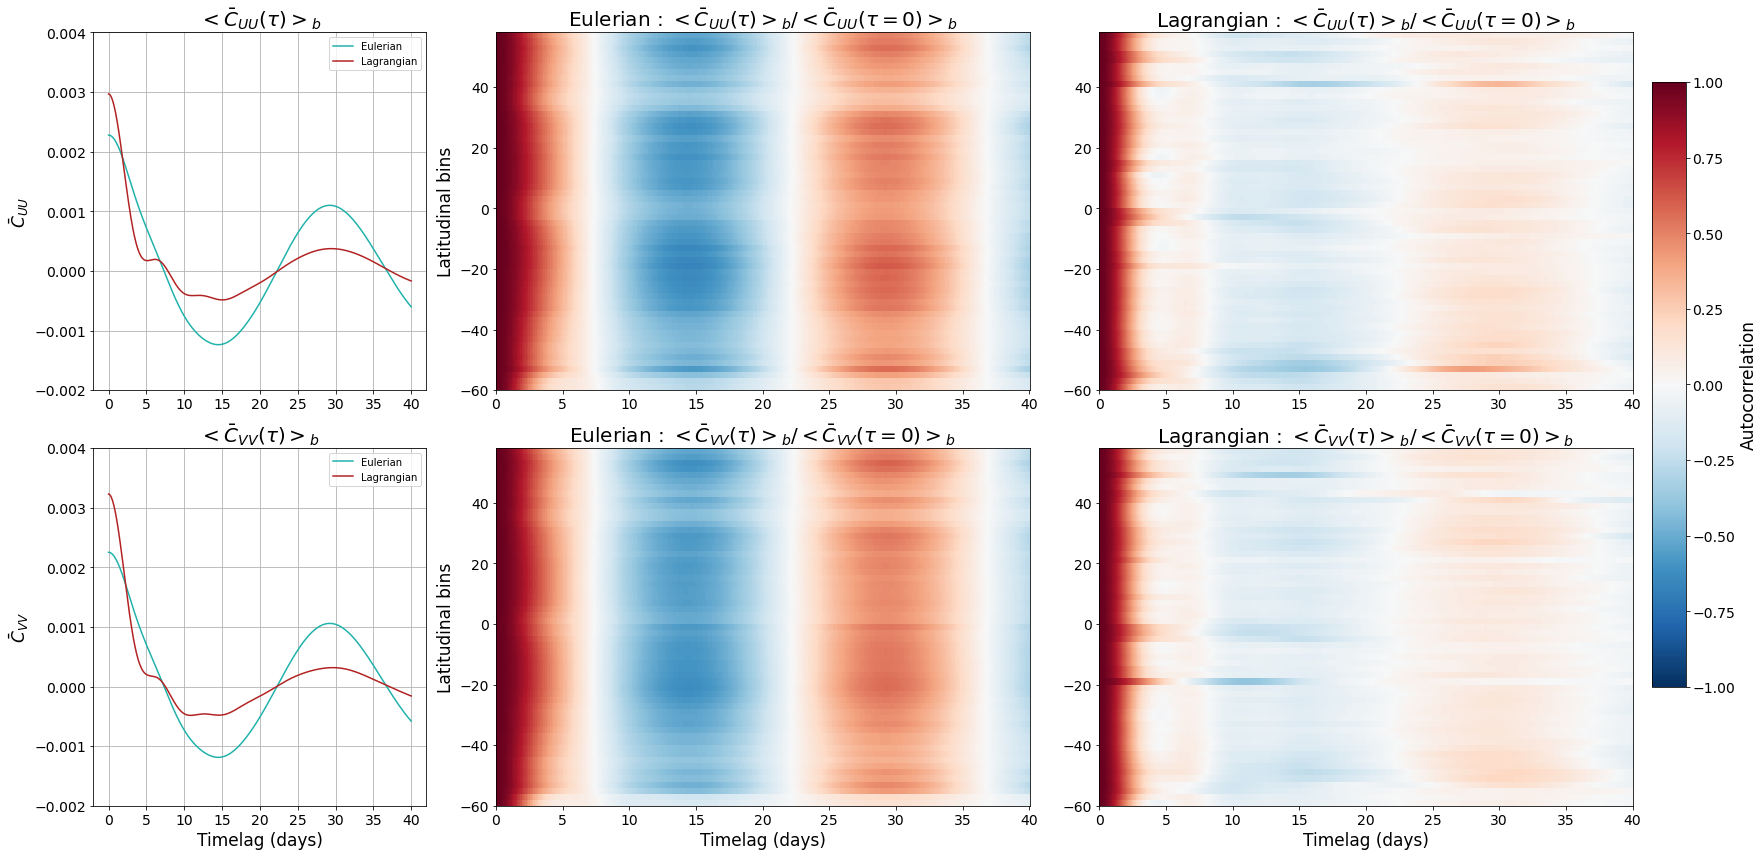

In [9]:
import matplotlib as mpl
with mpl.rc_context({'axes.titlesize': 20,'axes.labelsize':17,'xtick.labelsize':14,'ytick.labelsize':14}):
    fig = plt.figure(figsize=(23, 12), constrained_layout=True)
    spec = fig.add_gridspec(2, 8)

    for i,v in enumerate(['rr_SSU','rr_SSV']):
        ax = fig.add_subplot(spec[i, 2:5])
        comp = v[-1]
        cs = (dsE[v].mean('lon_bins')/dsE[v].mean('lon_bins').isel(lags=0)
        ).plot(cmap='RdBu_r',ax=ax,y='lat_bins',vmax=1,vmin=-1,add_colorbar=False);
        ax.set_title(r'Eulerian : $<\bar C_{%s%s}(\tau)>_b/<\bar C_{%s%s}(\tau=0)>_b$'%(v[-1],v[-1],v[-1],v[-1]));
        ax.set_ylabel('Latitudinal bins');ax.set_xlabel('')
        ax1 = fig.add_subplot(spec[i, 5:],sharex=ax)
        (dsL[v].mean('lon_bins')/dsL[v].mean('lon_bins').isel(lags=0)
        ).plot(cmap='RdBu_r',ax=ax1,y='lat_bins',vmax=1,vmin=-1,add_colorbar=False);
        ax1.set_title(r'Lagrangian : $<\bar C_{%s%s}(\tau)>_b/<\bar C_{%s%s}(\tau=0)>_b$'%(v[-1],v[-1],v[-1],v[-1]));
        ax1.set_ylabel('');ax1.set_xlabel('')
        ax2 = fig.add_subplot(spec[i, :2])
        dsE[v].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='lightseagreen',label='Eulerian');
        dsL[v].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='firebrick',label='Lagrangian');
        ax2.set_title(r'$<\bar C_{%s%s}(\tau)>_b$'%(v[-1],v[-1]));
        ax2.set_ylabel(r'$\bar C_{%s%s}$'%(v[-1],v[-1]));
        ax2.grid();ax2.legend();ax2.set_xlabel('')
    ax1.set_xlabel('Timelag (days)');ax.set_xlabel('Timelag (days)');ax2.set_xlabel('Timelag (days)')
    cbar_ax = fig.add_axes([1., 0.2, 0.02, 0.7])
    cb = fig.colorbar(cs, cax=cbar_ax)#
    cb.set_label('Autocorrelation',size=17)
    #annotate_axes(ax0, 'ax0')
    fig.tight_layout()
    fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/EL_autocov_norm_hf.png',bbox_inches='tight')

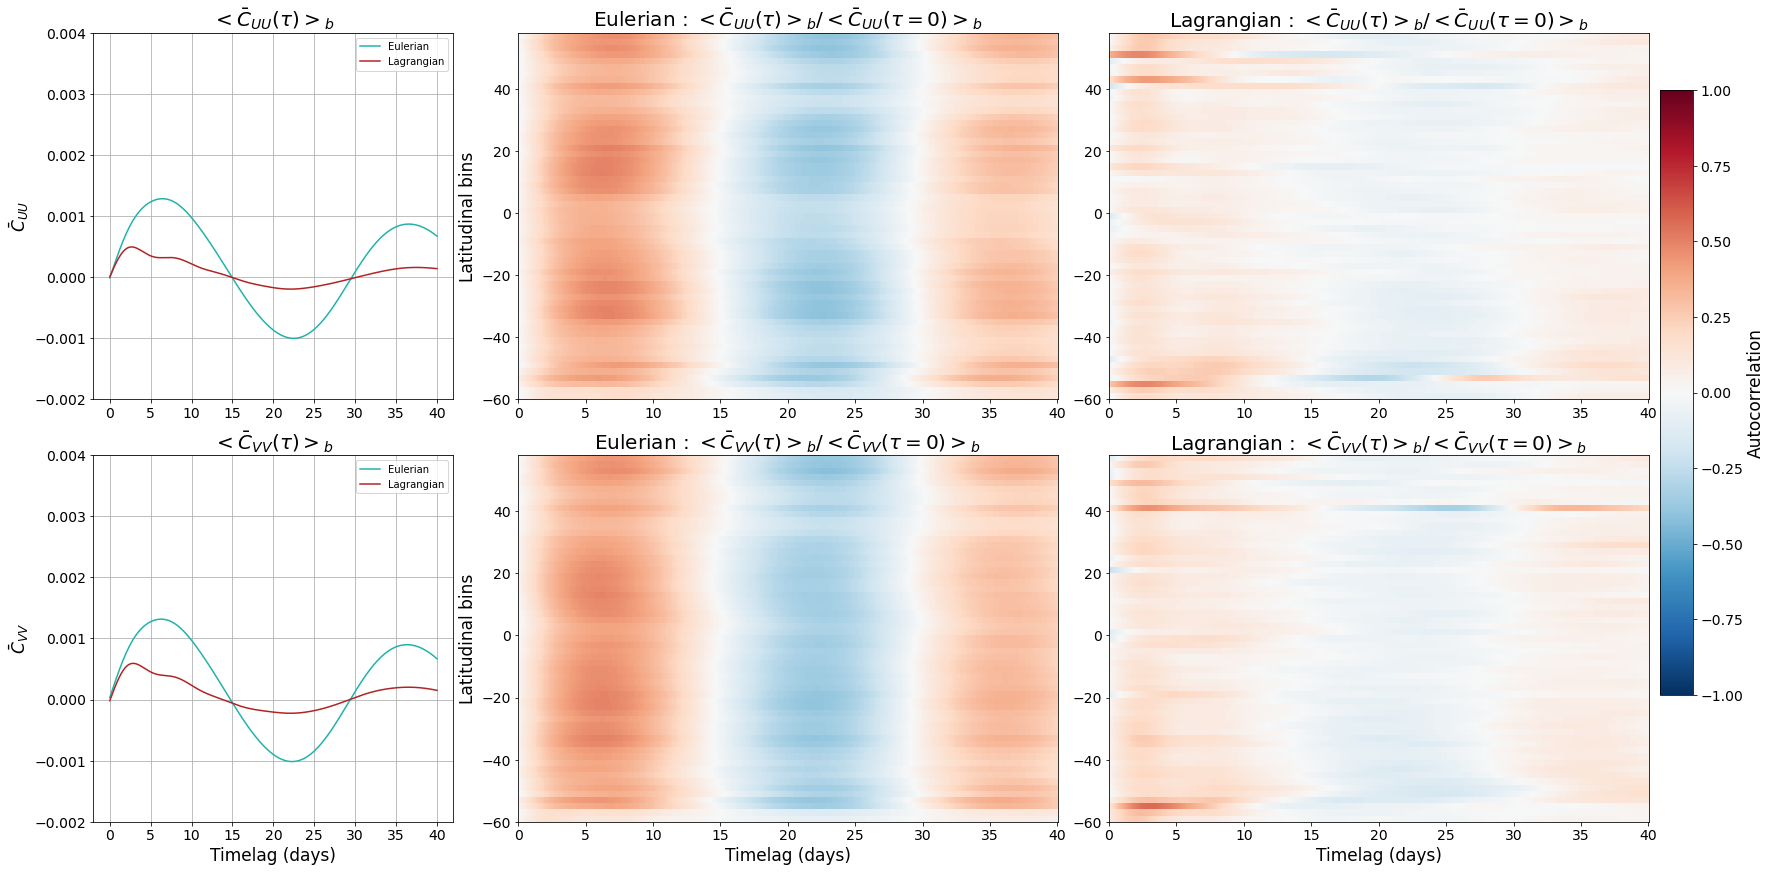

In [12]:
import matplotlib as mpl
with mpl.rc_context({'axes.titlesize': 20,'axes.labelsize':17,'xtick.labelsize':14,'ytick.labelsize':14}):
    fig = plt.figure(figsize=(23, 12), constrained_layout=True)
    spec = fig.add_gridspec(2, 8)

    for i,v in enumerate(['ri_SSU','ri_SSV']):
        ax = fig.add_subplot(spec[i, 2:5])
        comp = v[-1]
        cs=(dsE[v].mean('lon_bins')/(dsE['rr_'+v[-3:]].mean('lon_bins').isel(lags=0))
        ).plot(cmap='RdBu_r',ax=ax,y='lat_bins',vmax=1,vmin=-1,add_colorbar=False);
        ax.set_title(r'Eulerian : $<\bar C_{%s%s}(\tau)>_b/<\bar C_{%s%s}(\tau=0)>_b$'%(v[-1],v[-1],v[-1],v[-1]));
        ax.set_ylabel('Latitudinal bins');ax.set_xlabel('')
        ax1 = fig.add_subplot(spec[i, 5:],sharex=ax)
        (dsL[v].mean('lon_bins')/(dsL['rr_'+v[-3:]].mean('lon_bins').isel(lags=0))
        ).plot(cmap='RdBu_r',ax=ax1,y='lat_bins',vmax=1,vmin=-1,add_colorbar=False);
        ax1.set_title(r'Lagrangian : $<\bar C_{%s%s}(\tau)>_b/<\bar C_{%s%s}(\tau=0)>_b$'%(v[-1],v[-1],v[-1],v[-1]));
        ax1.set_ylabel('');ax1.set_xlabel('')
        ax2 = fig.add_subplot(spec[i, :2])
        dsE[v].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='lightseagreen',label='Eulerian');
        dsL[v].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='firebrick',label='Lagrangian');
        ax2.set_title(r'$<\bar C_{%s%s}(\tau)>_b$'%(v[-1],v[-1]));
        ax2.set_ylabel(r'$\bar C_{%s%s}$'%(v[-1],v[-1]));
        ax2.grid();ax2.legend();ax2.set_xlabel('')
    ax1.set_xlabel('Timelag (days)');ax.set_xlabel('Timelag (days)');ax2.set_xlabel('Timelag (days)')
    cbar_ax = fig.add_axes([1., 0.2, 0.02, 0.7])
    cb = fig.colorbar(cs, cax=cbar_ax)#
    cb.set_label('Autocorrelation',size=17)
    #annotate_axes(ax0, 'ax0')
  #  fig.tight_layout()
    fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/EL_autocov_norm_ri_hf.png',bbox_inches='tight')

/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_1792/1404311787.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_1792/1404311787.py:29: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


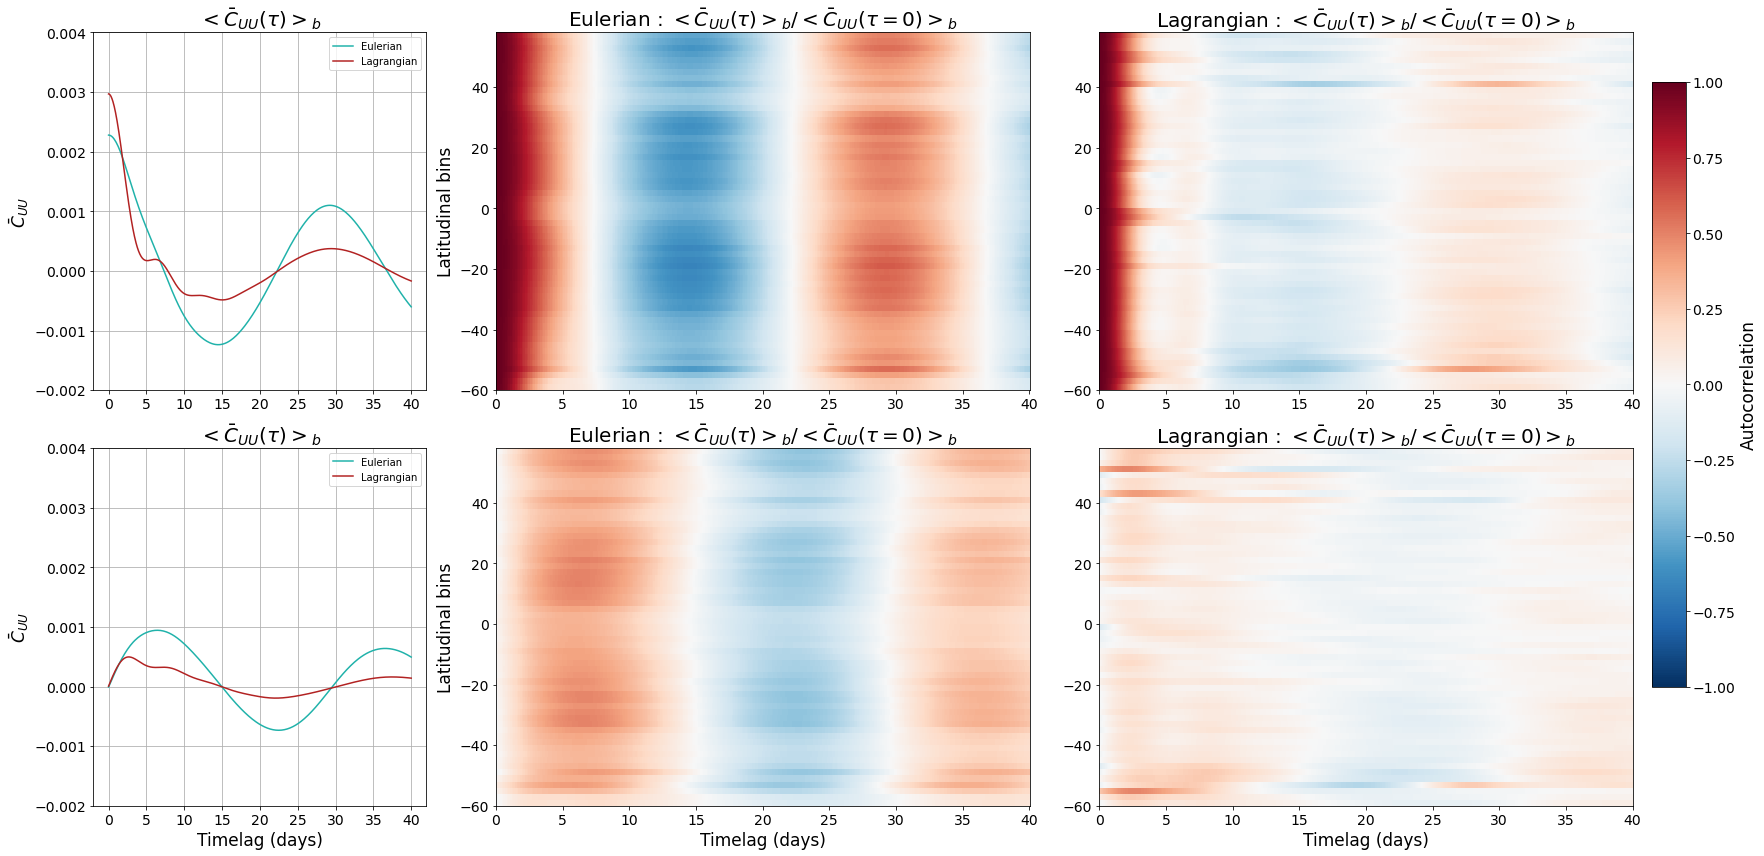

In [8]:
import matplotlib as mpl
with mpl.rc_context({'axes.titlesize': 20,'axes.labelsize':17,'xtick.labelsize':14,'ytick.labelsize':14}):
    fig = plt.figure(figsize=(23, 12), constrained_layout=True)
    spec = fig.add_gridspec(2, 8)

    for i,v in enumerate(['rr_SSU','ri_SSU']):
        ax = fig.add_subplot(spec[i, 2:5])
        comp = v[-1]
        cs = (dsE[v].mean('lon_bins')/dsE['rr_SSU'].mean('lon_bins').isel(lags=0)
        ).plot(cmap='RdBu_r',ax=ax,y='lat_bins',vmax=1,vmin=-1,add_colorbar=False);
        ax.set_title(r'Eulerian : $<\bar C_{%s%s}(\tau)>_b/<\bar C_{%s%s}(\tau=0)>_b$'%(v[-1],v[-1],v[-1],v[-1]));
        ax.set_ylabel('Latitudinal bins');ax.set_xlabel('')
        ax1 = fig.add_subplot(spec[i, 5:],sharex=ax)
        (dsL[v].mean('lon_bins')/dsL['rr_SSU'].mean('lon_bins').isel(lags=0)
        ).plot(cmap='RdBu_r',ax=ax1,y='lat_bins',vmax=1,vmin=-1,add_colorbar=False);
        ax1.set_title(r'Lagrangian : $<\bar C_{%s%s}(\tau)>_b/<\bar C_{%s%s}(\tau=0)>_b$'%(v[-1],v[-1],v[-1],v[-1]));
        ax1.set_ylabel('');ax1.set_xlabel('')
        ax2 = fig.add_subplot(spec[i, :2])
        dsE[v].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='lightseagreen',label='Eulerian');
        dsL[v].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='firebrick',label='Lagrangian');
        ax2.set_title(r'$<\bar C_{%s%s}(\tau)>_b$'%(v[-1],v[-1]));
        ax2.set_ylabel(r'$\bar C_{%s%s}$'%(v[-1],v[-1]));
        ax2.grid();ax2.legend();ax2.set_xlabel('')
    ax1.set_xlabel('Timelag (days)');ax.set_xlabel('Timelag (days)');ax2.set_xlabel('Timelag (days)')
    cbar_ax = fig.add_axes([1., 0.2, 0.02, 0.7])
    cb = fig.colorbar(cs, cax=cbar_ax)#
    cb.set_label('Autocorrelation',size=17)
    #annotate_axes(ax0, 'ax0')
    fig.tight_layout()
    fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/EL_cov_norm_hf.png',bbox_inches='tight')

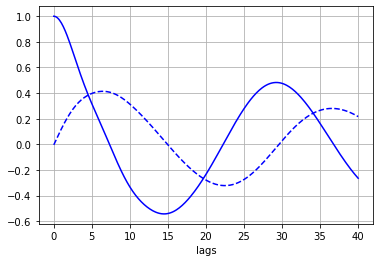

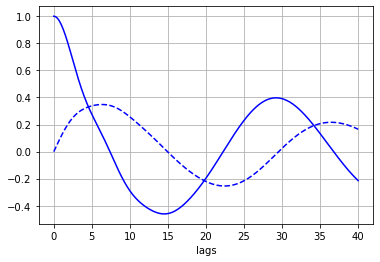

In [15]:
(dsE['rr_SSU'].mean(['lon_bins','lat_bins'])/dsE['rr_SSU'].mean(['lon_bins','lat_bins']).isel(lags=0)
).plot(c = 'b')
(dsE['ri_SSU'].mean(['lon_bins','lat_bins'])/dsE['rr_SSU'].mean(['lon_bins','lat_bins']).isel(lags=0)
).plot(c = 'b',linestyle='--')
plt.grid()


plt.figure()
(dsE['rr_SSU']/dsE['rr_SSU'].isel(lags=0)).mean(['lon_bins','lat_bins']).plot(c = 'b')
(dsE['ri_SSU']/dsE['rr_SSU'].isel(lags=0)).mean(['lon_bins','lat_bins']).plot(c = 'b',linestyle='--')
plt.grid()

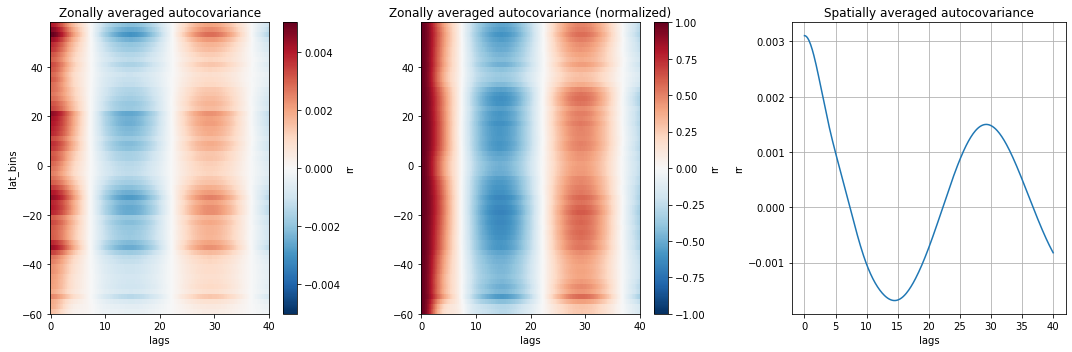

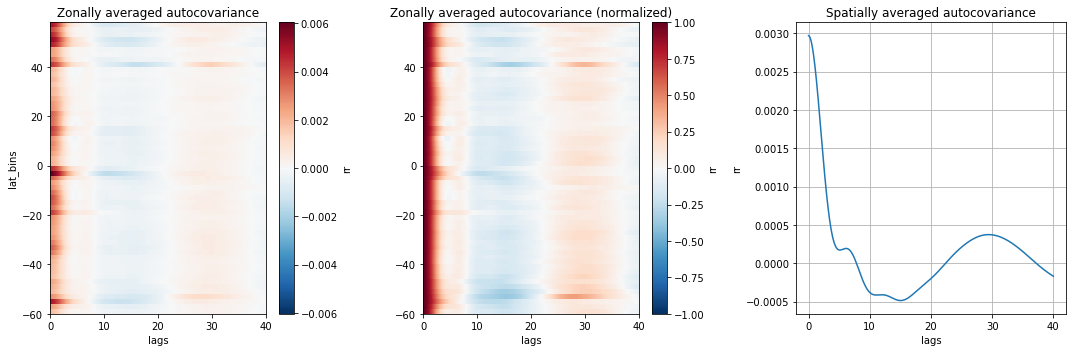

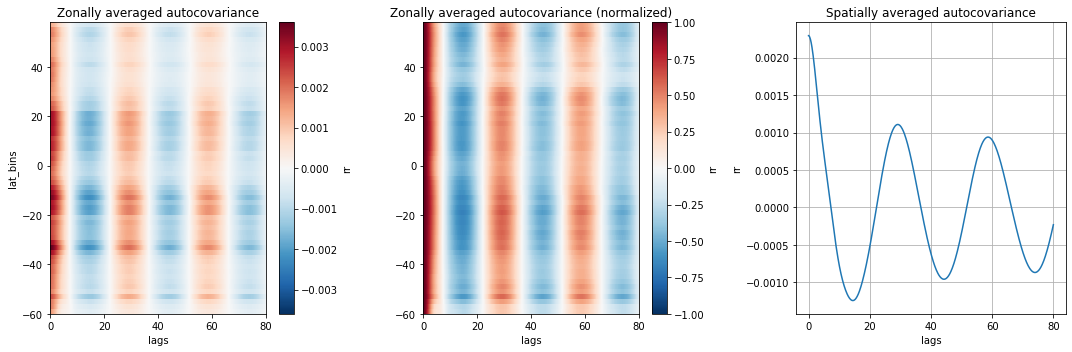

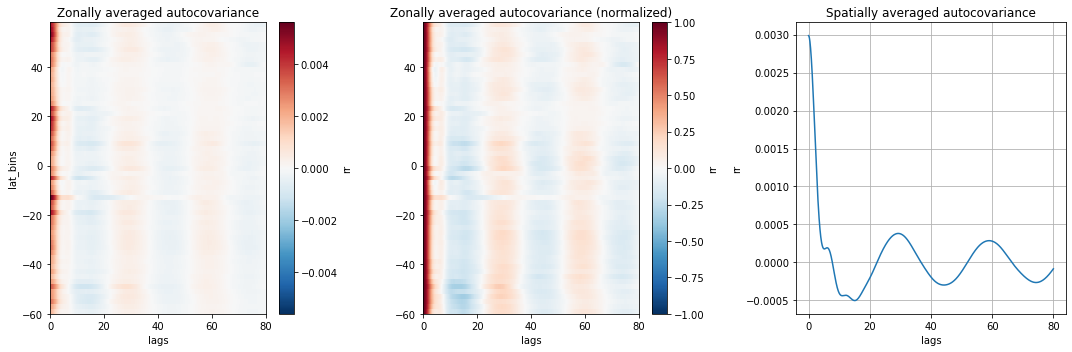

In [19]:

fig,axs = plt.subplots(1,3,figsize=(15,5))
dsE.rr.mean('lon_bins').plot(ax=axs[0],y='lat_bins');axs[0].set_title('Zonally averaged autocovariance')
(dsE.rr.mean('lon_bins')/dsE.rr.mean('lon_bins').isel(lags=0)).plot(ax=axs[1],y='lat_bins');
axs[1].set_title('Zonally averaged autocovariance (normalized)')
dsE.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2]);
#dsL_80.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2],xlim=(0,40));
axs[2].set_title('Spatially averaged autocovariance')
axs[1].set_ylabel('')
axs[2].grid();
fig.tight_layout()

fig,axs = plt.subplots(1,3,figsize=(15,5))
dsL.rr.mean('lon_bins').plot(ax=axs[0]);axs[0].set_title('Zonally averaged autocovariance')
(dsL.rr.mean('lon_bins')/dsL.rr.mean('lon_bins').isel(lags=0)).plot(ax=axs[1]);
axs[1].set_title('Zonally averaged autocovariance (normalized)')
dsL.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2]);
#dsL_80.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2],xlim=(0,40));
axs[2].set_title('Spatially averaged autocovariance')
axs[1].set_ylabel('')
axs[2].grid();
fig.tight_layout()

fig,axs = plt.subplots(1,3,figsize=(15,5))
dsE_80.rr.mean('lon_bins').plot(ax=axs[0],y='lat_bins');axs[0].set_title('Zonally averaged autocovariance')
(dsE_80.rr.mean('lon_bins')/dsE_80.rr.mean('lon_bins').isel(lags=0)).plot(ax=axs[1],y='lat_bins');
axs[1].set_title('Zonally averaged autocovariance (normalized)')
dsE_80.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2]);
axs[2].set_title('Spatially averaged autocovariance')
axs[1].set_ylabel('')
axs[2].grid();
fig.tight_layout()

fig,axs = plt.subplots(1,3,figsize=(15,5))
dsL_80.rr.mean('lon_bins').plot(ax=axs[0],y='lat_bins');axs[0].set_title('Zonally averaged autocovariance')
(dsL_80.rr.mean('lon_bins')/dsL_80.rr.mean('lon_bins').isel(lags=0)).plot(ax=axs[1],y='lat_bins');
axs[1].set_title('Zonally averaged autocovariance (normalized)')
dsL_80.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2]);
axs[2].set_title('Spatially averaged autocovariance')
axs[1].set_ylabel('')
axs[2].grid();
fig.tight_layout()



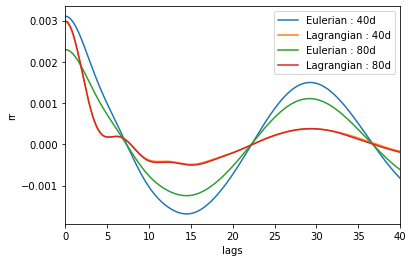

In [22]:
dsE.rr.mean(['lat_bins','lon_bins']).plot(label='Eulerian : 40d')
dsL.rr.mean(['lat_bins','lon_bins']).plot(label='Lagrangian : 40d')
dsE_80.rr.mean(['lat_bins','lon_bins']).plot(xlim=(0,40),label='Eulerian : 80d')
dsL_80.rr.mean(['lat_bins','lon_bins']).plot(xlim=(0,40),label='Lagrangian : 80d')
plt.legend()

In [15]:
# Area of interest
bbox_cal = [-125,35] #california
bbox_med = [4,40] # mediterranean sea
bbox_nwa = [115,-15] # North-west Australia
bbox_nea = [160,-15] # North-west Australia
bbox_swa = [120,-40] # South-west Australia
#bbox_neh = [-160, 35] # North-east Hawaii
bbox_eq = [-125,0] #equator
bbox_atl = [-10,-20]

boxes = {'California':bbox_cal,'North-Eat Australia':bbox_nea,'Mediterranean sea':bbox_med,
         'South atlantic ridge':bbox_atl}

Text(0.5, 0.98, 'Lagrangian autocovariance')

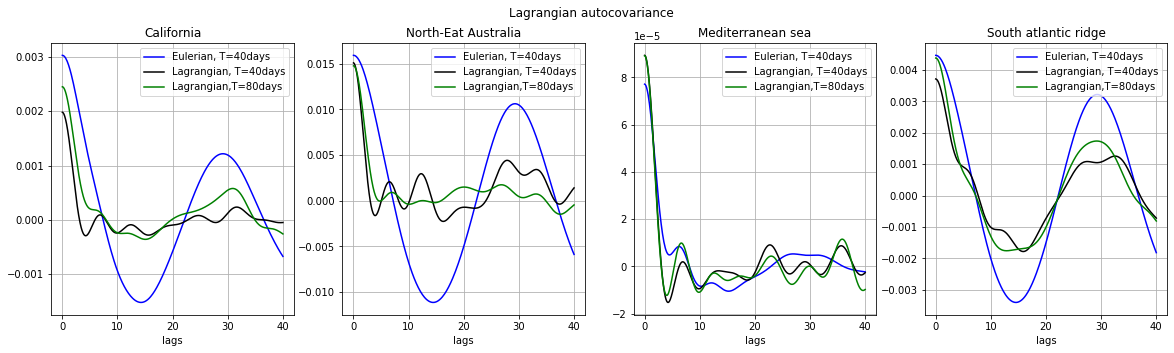

In [16]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='b',label='Eulerian, T=40days')
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Lagrangian, T=40days')
    dsL_80.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).sel(lags=slice(0,40)).plot(ax=ax,c='g',label='Lagrangian,T=80days')
#    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
#                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend()
fig.suptitle('Lagrangian autocovariance')

Text(0.5, 0.98, 'Lagrangian autocovariance')

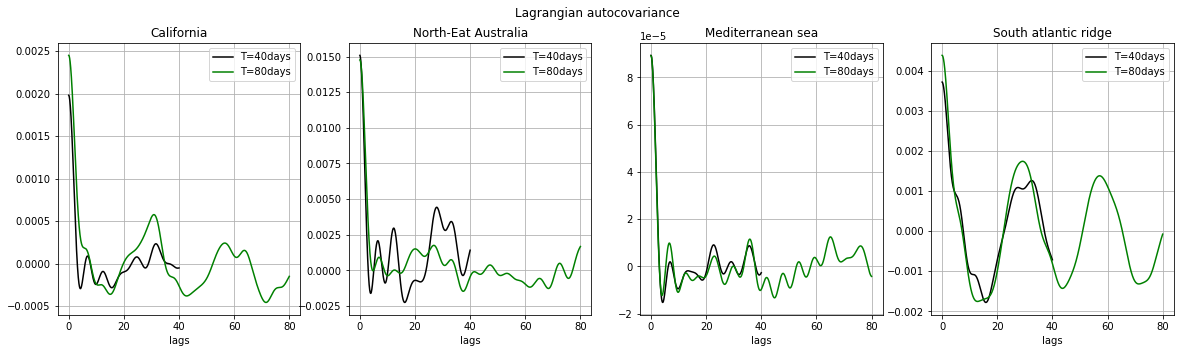

In [17]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='T=40days')
    dsL_80.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='g',label='T=80days')
#    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
#                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend()
fig.suptitle('Lagrangian autocovariance')

### Estimation of paraeters : fit 

In [8]:
dt = 3/24 # time step in days
rad = 2*np.pi
tau = np.arange(0,dsL.lags.max()+dt,dt) #time lag
tau80 = np.arange(0,dsL_80.lags.max()+dt,dt) #time lag

In [9]:
def fit_function(y,t=None,myfunc=None,first_guess='free',bounds=None,sigma=None):
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        y : data to fit
        t : timelag of the correlation function
        myfunc : function we want to fit to our data, y
        p0 : first guess on parameters
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        params : parameters for which we obtain the best fit
        error : covariance of params computed in scipy.optimize.curve_fit
        yfit : best fit
        """
    sig = signature(myfunc)
    len_sig = len(sig.parameters.keys())
    try : 
        if first_guess=='lag' and sigma is None:
            _p0 = np.full(len_sig-1,1)
            _p0[-1] = y[0]
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000)
    #    try:
        if sigma is not None:
            if first_guess=='lag':
                _p0 = np.full(len_sig-1,1)
                _p0[-1] = y[0]
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
            else:
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
        else:
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000)
        yfit = myfunc(t,*[p for p in params])
        error=np.sqrt(np.diag(cov))
    except:
#        print("error")
        params,error = np.full(len_sig-1,np.nan),np.full(len_sig-1,np.nan)
        yfit = np.full_like(t,np.nan)
#        out = xr.Dataset({'params':(['lat_bins','lon_bins','param'],np.expand_dims(params, axis=0)),
#                      'fitted':(['lat_bins','lon_bins','lags'],np.expand_dims(yfit,axis=0)),
#                     'error' : (['lat_bins','lon_bins','param'],np.expand_dims(cov,axis=0))},
 #                    coords={'lat_bins':np.array([y.lat_bins.values]),'lon_bins':np.array([y.lon_bins.values])
 #                            ,'param':[V for V in sig.parameters.keys()][1:],
 #                            'lags':y.lags.values})
    return params,error,yfit
def wrapper(ds,v,myfunc,t,bounds,p0='free',sigma=None):
    sig = signature(myfunc)
    params_name = [V for V in sig.parameters.keys()][1:]
    kwargs={'t':t,'myfunc':myfunc,'first_guess':p0,'bounds':bounds}
    if sigma is not None:
        kwargs.update({'sigma':sigma})
        
    print('Parameters to estimate:',params_name)
    params,error,yfit = xr.apply_ufunc(fit_function,ds[v],input_core_dims=[['lags']],
                                   output_core_dims=[['param'],['param'],['lags']],
                                   vectorize=True,kwargs=kwargs)
    params = params.rename('parameters').assign_coords({'param':params_name})
    error = error.rename('error').assign_coords({'param':params_name})
    ds_out = xr.merge([params,error,yfit])
#    ds_out = ds_out.where(ds_out[v].isel(lags=0)>1e-18)
    return ds_out

In [10]:
sigma = np.ones(tau.size)*1.
#sigma[:int(20/dt)] = 0.5
#sigma[0] = 0.1

In [11]:
#dsL = dsL_80.isel(lags=slice(0,int(40*24+24/9),3))
dsL = dsL.isel(lags=slice(0,None,3))

In [14]:
dsL

<xarray.Dataset>
Dimensions:   (lat_bins: 59, lon_bins: 179, lags: 321)
Coordinates:
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lags      (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    rr_SSU    (lat_bins, lon_bins, lags) float64 ...
    ri_SSU    (lat_bins, lon_bins, lags) float64 ...
    count     (lat_bins, lon_bins) float64 0.0 1.0 0.0 0.0 ... 14.0 11.0 14.0
    rr_SSV    (lat_bins, lon_bins, lags) float64 ...
    ri_SSV    (lat_bins, lon_bins, lags) float64 ...

In [17]:
dsE_out_Eta = wrapper(dsE_Eta,'rr',y_fit,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))

dsL_out_Eta = wrapper(dsL_Eta,'rr',y_fit,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))

Parameters to estimate: ['T', 'V']


NameError: name 'dsL_Eta' is not defined

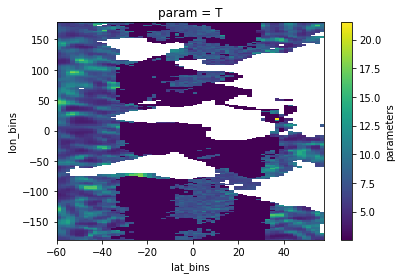

In [18]:
dsE_out_Eta.sel(param='T').parameters.plot()

In [12]:
def y_gauss(tau,T,V):
    return V*np.exp(-((tau)/T)**2)*np.cos(rad*omega_sn*tau)

def y_gauss_ri(tau,T,V):
    return V*np.exp(-((tau)/T)**2)*np.sin(rad*omega_sn*tau)

In [31]:
def yfit_mixed(tau,T,V,Vinc):
    return (V+Vinc*np.exp(-tau/T))*np.cos(rad*omega_sn*tau)

In [32]:
dsE_out = wrapper(dsE,'rr_SSU',yfit_mixed,tau,sigma=sigma,bounds=([2.5,0,0],[1000,np.inf,np.inf]))
dsL_out = wrapper(dsL,'rr_SSU',y_fit,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))
#dsL_out_gauss = wrapper(dsL,'rr_SSU',y_gauss,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))

Parameters to estimate: ['T', 'V', 'Vinc']
Parameters to estimate: ['T', 'V']


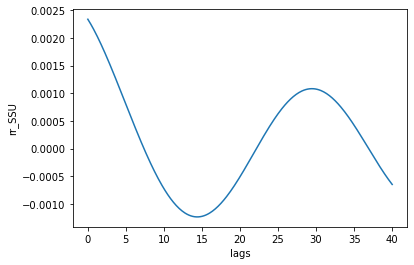

In [33]:
dsE_out.rr_SSU.mean(['lon_bins','lat_bins']).plot()

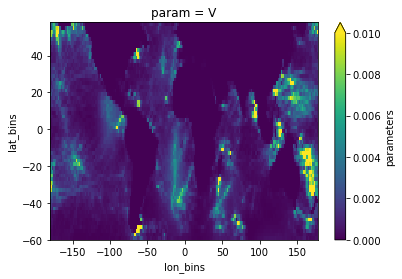

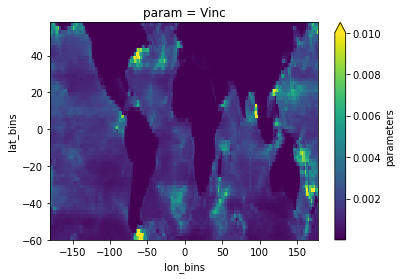

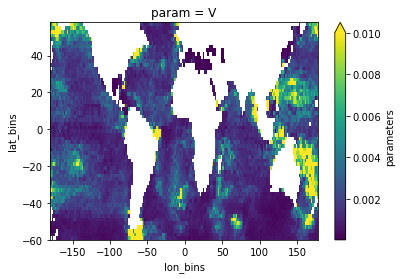

In [39]:
dsE_out.sel(param='V').parameters.plot(y='lat_bins',vmax=0.01)
plt.figure()
dsE_out.sel(param='Vinc').parameters.plot(y='lat_bins',vmax=0.01)
plt.figure()
dsL_out.sel(param='V').parameters.plot(y='lat_bins',vmax=0.01)

In [36]:
_dsE_out = wrapper(dsE,'rr_SSV',yfit_mixed,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))
#_dsL_out_gauss = wrapper(dsL,'rr_SSV',y_gauss,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))
_dsL_out = wrapper(dsL,'rr_SSV',yfit_mixed,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))

Parameters to estimate: ['T', 'V', 'Vinc']
Parameters to estimate: ['T', 'V', 'Vinc']


In [25]:
dsE_out_ri = wrapper(dsE,'ri_SSU',y_fit_ri,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))
dsL_out_gauss_ri = wrapper(dsL,'ri_SSU',y_gauss_ri,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))
dsL_out_ri = wrapper(dsL,'ri_SSU',y_fit_ri,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))

Parameters to estimate: ['T', 'V']
Parameters to estimate: ['T', 'V']
Parameters to estimate: ['T', 'V']


In [26]:
_dsE_out_ri = wrapper(dsE,'ri_SSV',y_fit_ri,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))
_dsL_out_gauss_ri = wrapper(dsL,'ri_SSV',y_gauss_ri,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))
_dsL_out_ri = wrapper(dsL,'ri_SSV',y_fit_ri,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))

Parameters to estimate: ['T', 'V']
Parameters to estimate: ['T', 'V']
Parameters to estimate: ['T', 'V']


In [37]:
def merge_fit(ds,dsV):
    """
    Returns merged dataset with best fit, corresponding paramters and their quadratic error for SSU and SSV.
    """
    dsV = dsV.rename({'parameters':'parameters_SSV','error':'error_SSV'})
    ds = ds.rename({'parameters':'parameters_SSU','error':'error_SSU'})
    ds = xr.merge([ds,dsV])
    return ds

In [38]:
dsE_out = merge_fit(dsE_out,_dsE_out)
dsL_out = merge_fit(dsL_out,_dsL_out)
#dsL_out_gauss = merge_fit(dsL_out_gauss,_dsL_out_gauss)

In [27]:
dsE_out_ri = merge_fit(dsE_out_ri,_dsE_out_ri)
dsL_out_ri = merge_fit(dsL_out_ri,_dsL_out_ri)
dsL_out_gauss_ri = merge_fit(dsL_out_gauss_ri,_dsL_out_gauss_ri)

In [23]:
dsE_out.to_netcdf('/Users/zcaspar/codes/mit4320/E_hf_fit_mixed.nc')
dsL_out.to_netcdf('/Users/zcaspar/codes/mit4320/L_hf_fit_mixed.nc')
#dsL_out_gauss.to_netcdf('/Users/zcaspar/codes/mit4320/L_hf_fit_gauss.nc')

In [29]:
dsE_out_ri.to_netcdf('/Users/zcaspar/codes/mit4320/E_hf_fit_ri.nc')
dsL_out_ri.to_netcdf('/Users/zcaspar/codes/mit4320/L_hf_fit_ri.nc')
dsL_out_gauss_ri.to_netcdf('/Users/zcaspar/codes/mit4320/L_hf_fit_gauss_ri.nc')

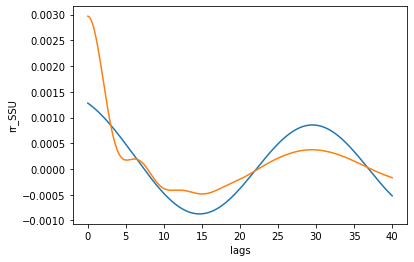

In [24]:
dsL_out.rr_SSU.mean(['lon_bins','lat_bins']).plot()
dsL.rr_SSU.mean(['lon_bins','lat_bins']).plot()
#sel(param='T').parameters.plot()

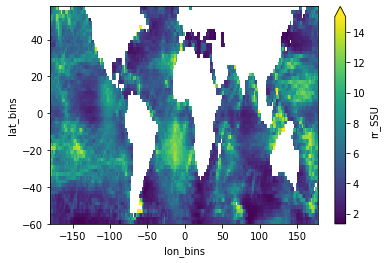

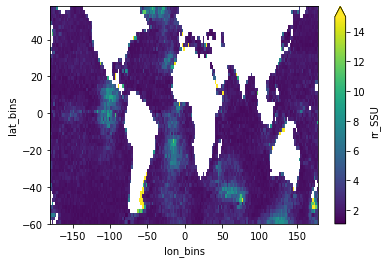

In [48]:
((dsE/dsE.isel(lags=0))**2).integrate('lags').rr_SSU.plot(x='lon_bins',vmax=15)

plt.figure()
((dsL/dsL.isel(lags=0))**2).integrate('lags').rr_SSU.plot(x='lon_bins',vmax=15)

In [25]:
#2 points in different areas : short E and L timescales, large E and L timescales, L << E, L>E
areas = {'South atlantic ridge' : [[-15,-5],[-15,-15],[-15,-25]],
        'Gulf stream' : [[-70,35],[-60,35]],
        'South Indian ocean' : [[58,-44],[78,-44]],
        'Pacific (equator)' : [[-100,-5],[-100,5],[-100,10]],
        'Pacific (south)' : [[-150,-20],[-140,-20],[-160,-20]]
        }

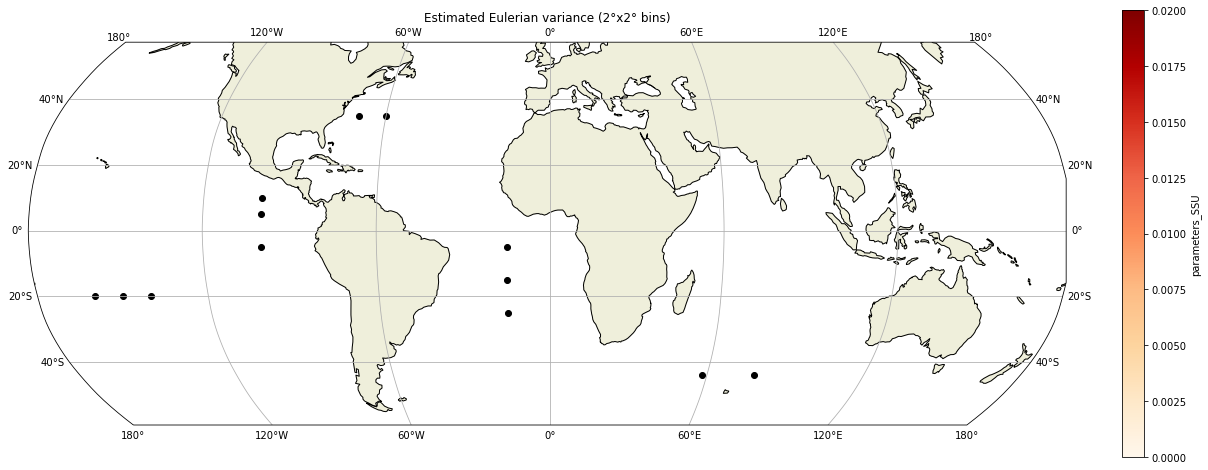

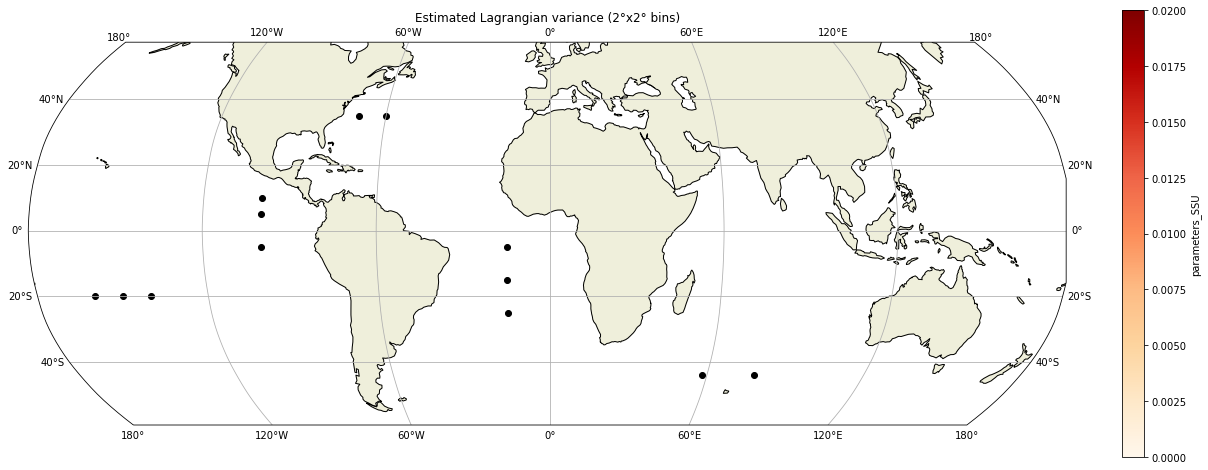

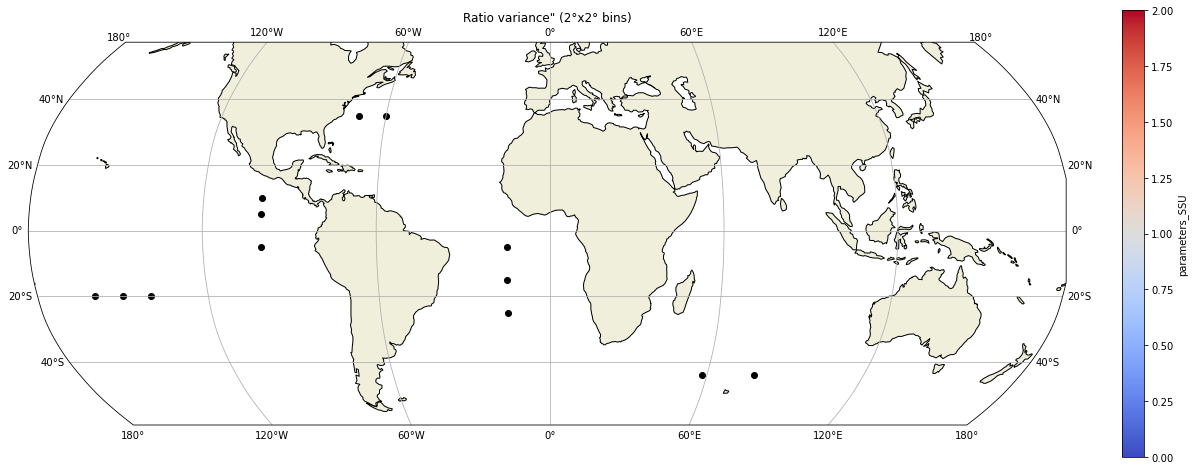

In [39]:
cmap='OrRd'
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(2*dsE_out.sel(param = 'V').parameters_SSU,colmap=cmap,vlim=(0,0.02))
ax.set_title('Estimated Eulerian variance (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(2*dsL_out.sel(param = 'V').parameters_SSU,colmap=cmap,vlim=(0,0.02))
ax.set_title('Estimated Lagrangian variance (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')
        
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out/dsE_out).sel(param = 'V').parameters_SSU,colmap='coolwarm',vlim=(0,2))
ax.set_title('Ratio variance" (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')

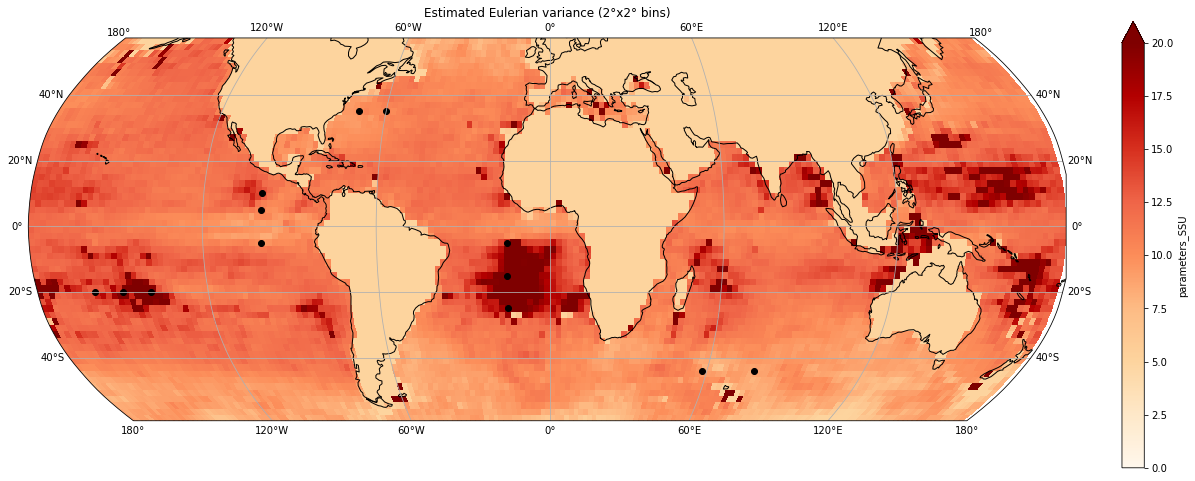

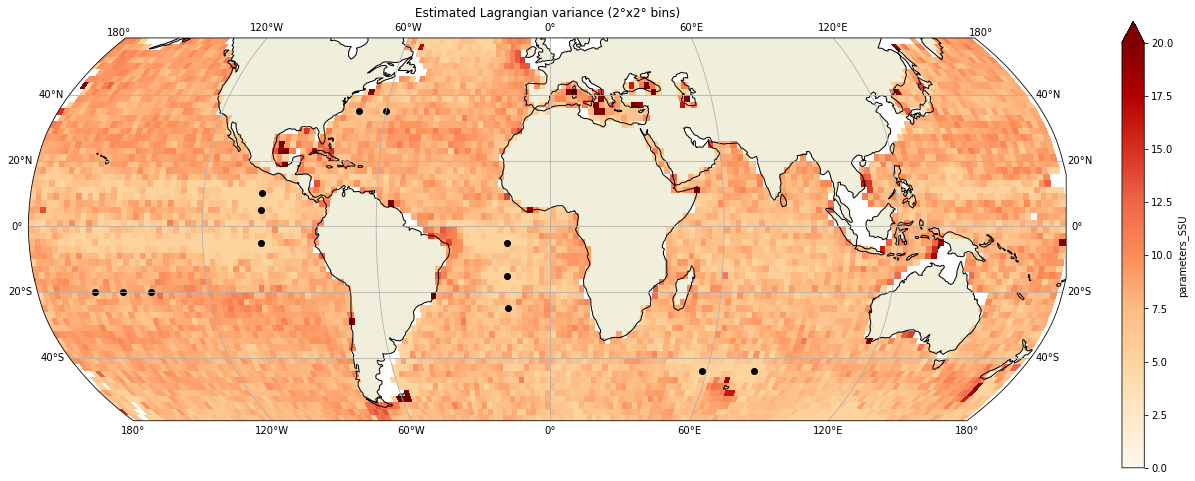

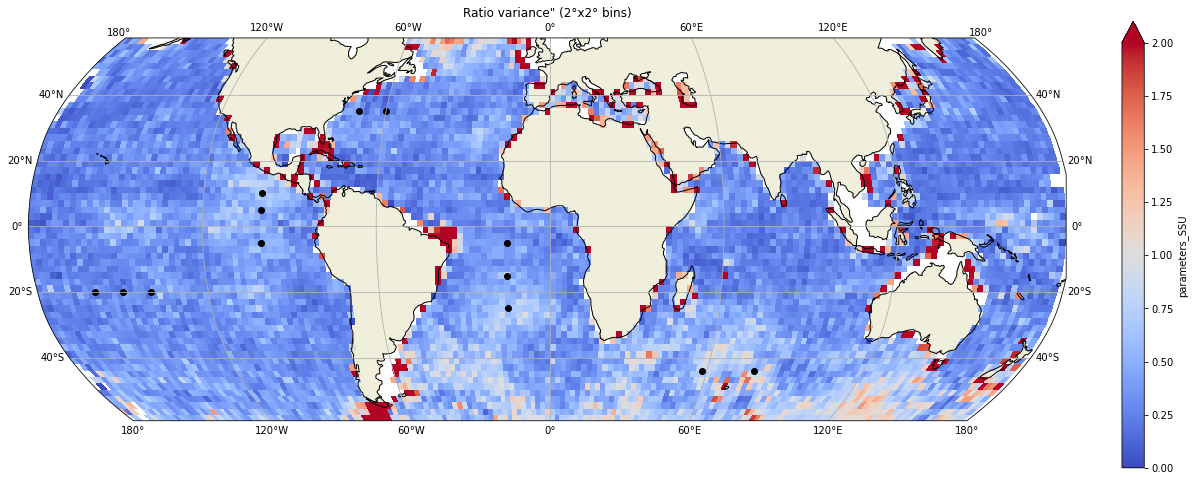

In [32]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(2*dsE_out.sel(param = 'T').parameters_SSU,colmap=cmap,vlim=(0,20))
ax.set_title('Estimated Eulerian variance (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(2*dsL_out.sel(param = 'T').parameters_SSU,colmap=cmap,vlim=(0,20))
ax.set_title('Estimated Lagrangian variance (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')
        
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out/dsE_out).sel(param = 'V').parameters_SSU,colmap='coolwarm',vlim=(0,2))
ax.set_title('Ratio variance" (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')

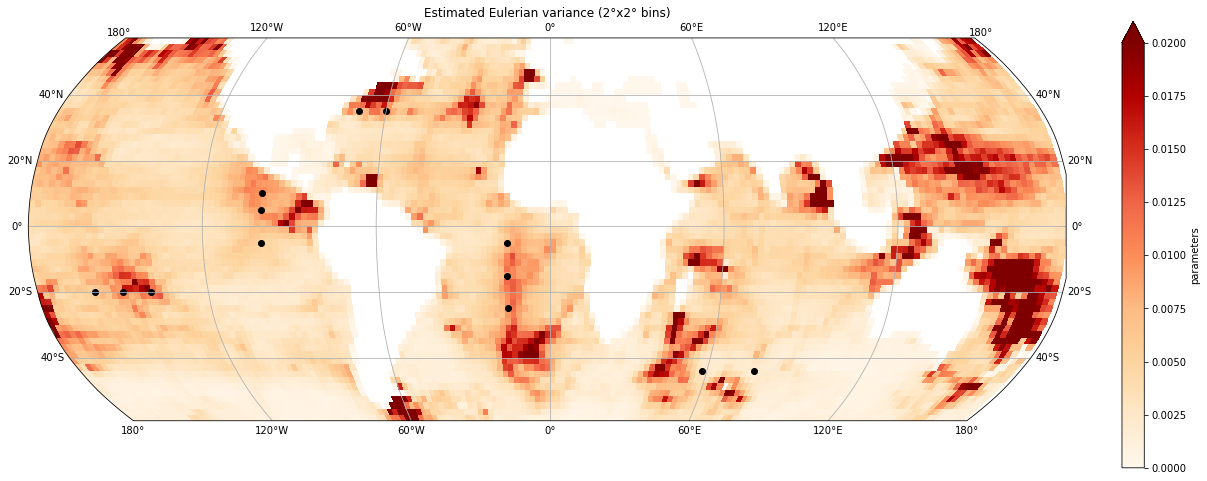

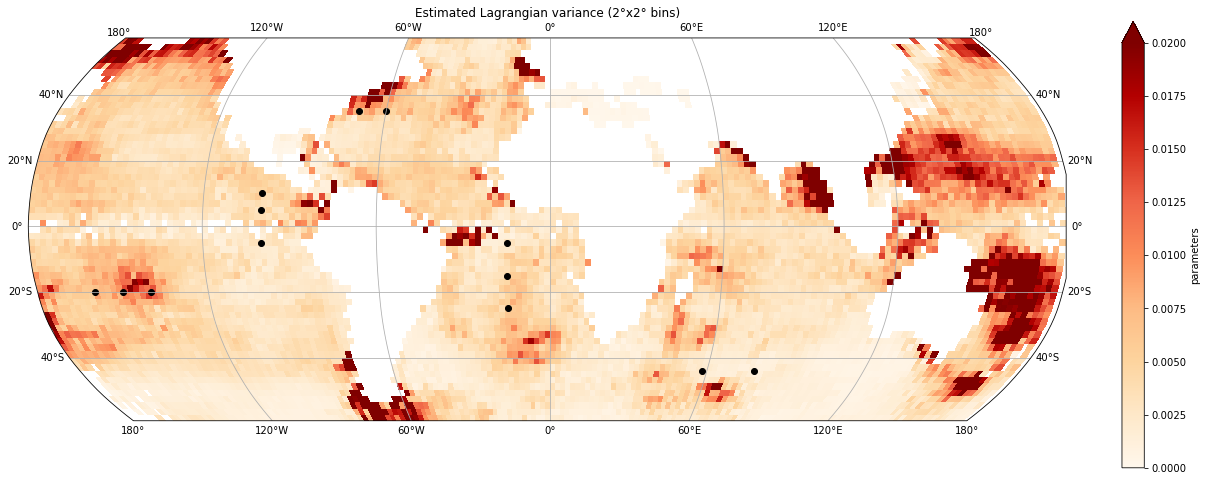

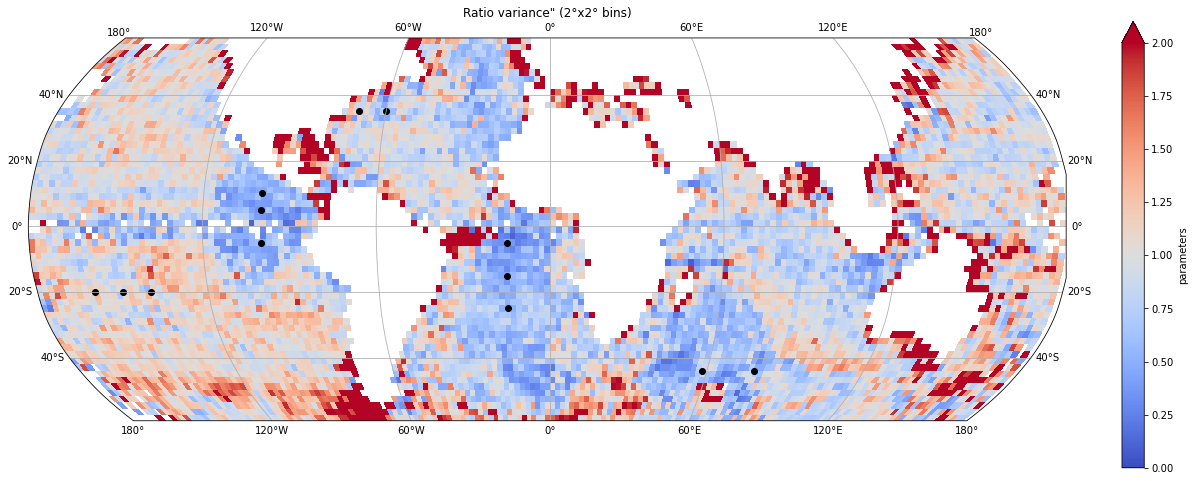

In [39]:
cmap='OrRd'
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(2*dsE_out.sel(param = 'V').parameters,colmap=cmap,vlim=(0,0.02))
ax.set_title('Estimated Eulerian variance (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(2*dsL_out.sel(param = 'V').parameters,colmap=cmap,vlim=(0,0.02))
ax.set_title('Estimated Lagrangian variance (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')
        
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out/dsE_out).sel(param = 'V').parameters,colmap='coolwarm',vlim=(0,2))
ax.set_title('Ratio variance" (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')

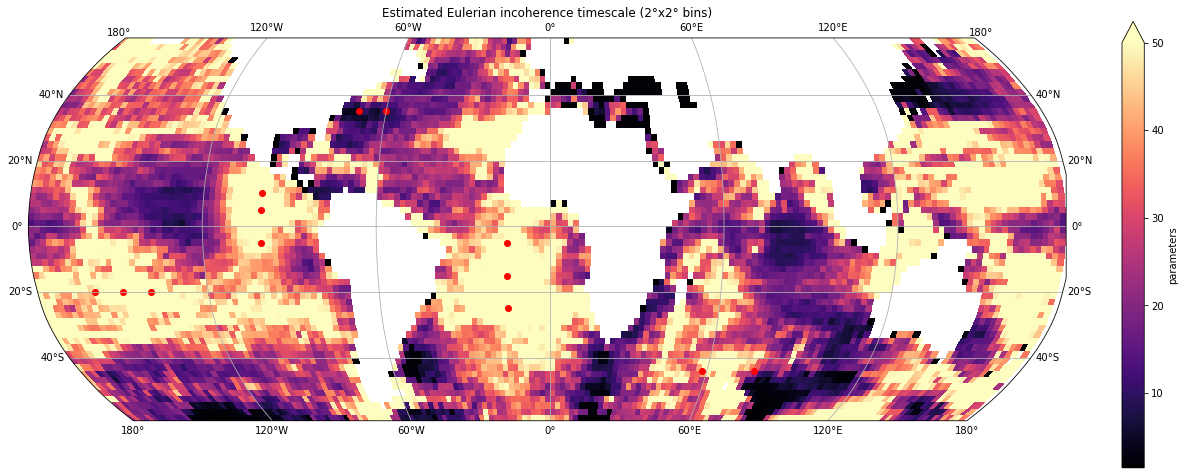

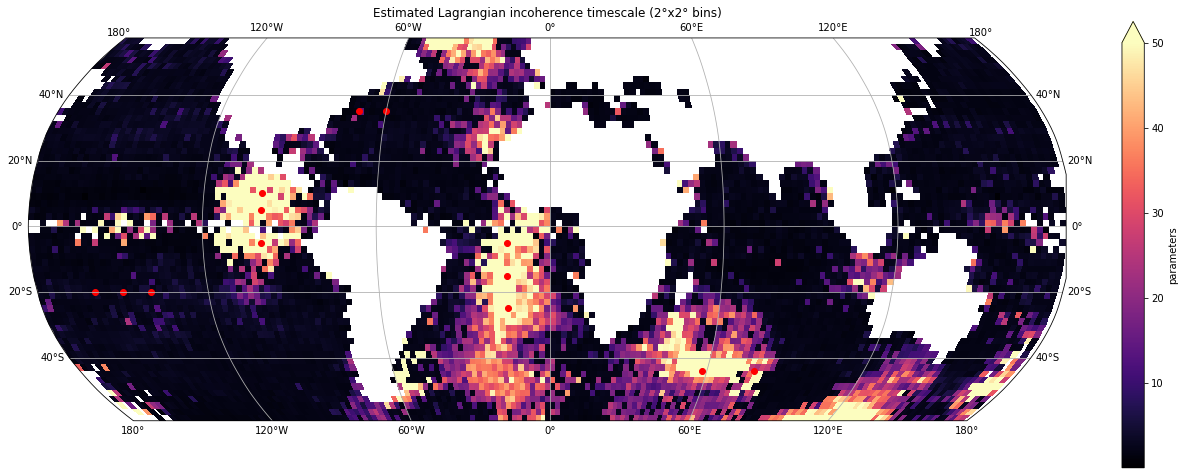

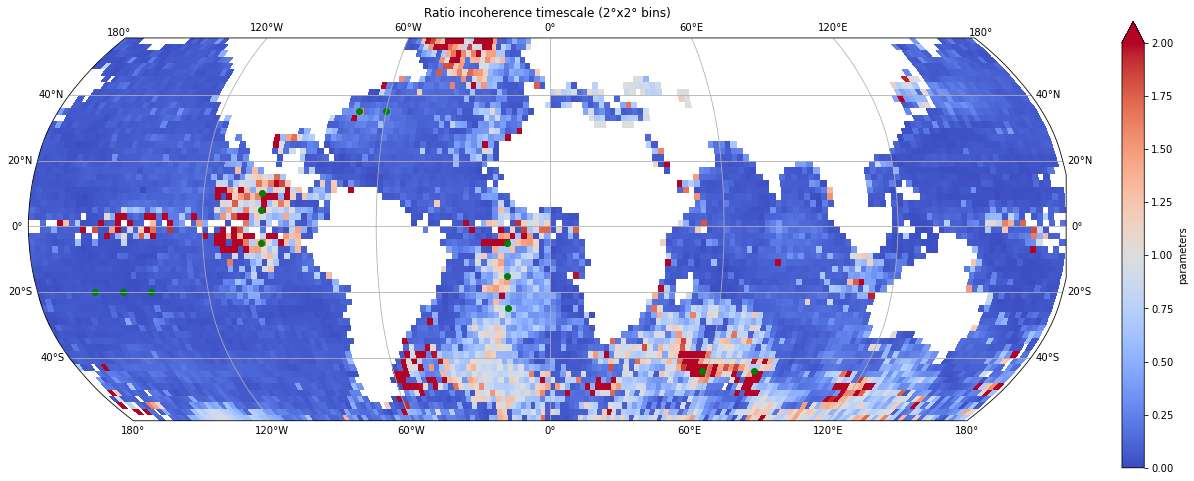

In [40]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,50))
ax.set_title('Estimated Eulerian incoherence timescale (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='r')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,50))
ax.set_title('Estimated Lagrangian incoherence timescale (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='r')
        
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out/dsE_out).sel(param = 'T').parameters,colmap='coolwarm',vlim=(0,2))
ax.set_title('Ratio incoherence timescale (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='g')
        


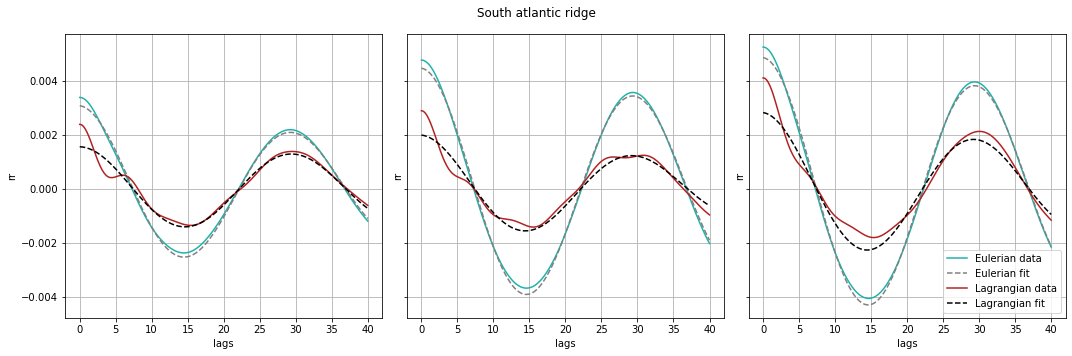

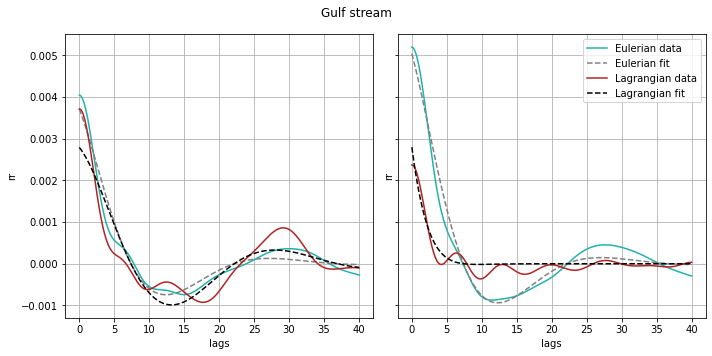

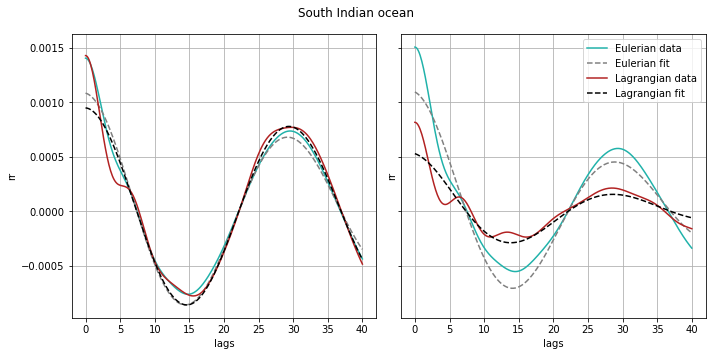

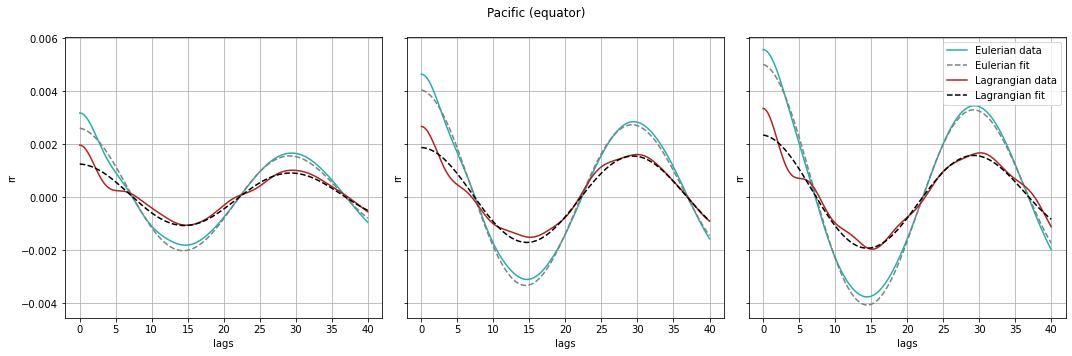

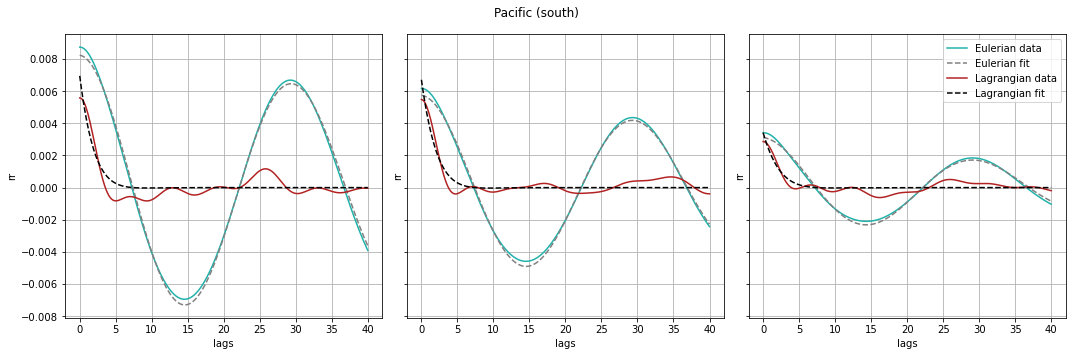

In [41]:
for k in areas.keys():
    fig,axs = plt.subplots(1,len(areas[k]),figsize=(5*len(areas[k]),5),sharey=True)
    for ax,pt in zip(axs,areas[k]):
        dsE.rr.sel(lat_bins=pt[1],lon_bins=pt[0],method='nearest').plot(ax=ax,c='lightseagreen',label='Eulerian data');
        dsE_out.rr.sel(lat_bins=pt[1],lon_bins=pt[0],method='nearest').plot(ax=ax,c='grey',linestyle='--',label='Eulerian fit');
        dsL.rr.sel(lat_bins=pt[1],lon_bins=pt[0],method='nearest').plot(ax=ax,c='firebrick',label='Lagrangian data');
        dsL_out.rr.sel(lat_bins=pt[1],lon_bins=pt[0],method='nearest').plot(ax=ax,c='k',linestyle='--',label='Lagrangian fit');
        ax.grid();ax.set_title('');
        low_var = dsE_low.rr.sel(lat_bins=pt[1],lon_bins=pt[0],method='nearest').isel(lags=0).values
#        ax.text(0,-0.004,r'$\overline{V}^2 \sim%s$'%np.around(low_var,decimals=4))
    ax.legend()
    fig.suptitle(k);fig.tight_layout();

In [52]:
def y_gauss(tau,T,V):
    return V*np.exp(-((tau)/T)**2)*np.cos(rad*omega_sn*tau)

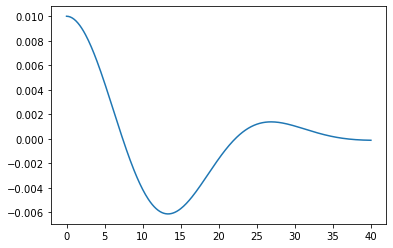

In [53]:
plt.plot(tau,y_gauss(tau,20,0.01))

In [54]:
dsE_gauss = wrapper(dsE,'rr_SSU',y_gauss,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))

dsL_gauss = wrapper(dsL,'rr_SSU',y_gauss,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))

Parameters to estimate: ['T', 'V']
Parameters to estimate: ['T', 'V']


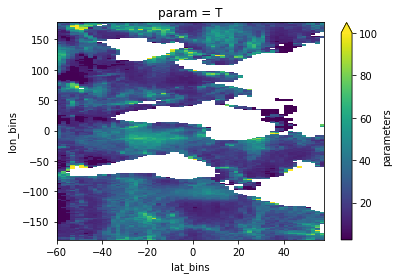

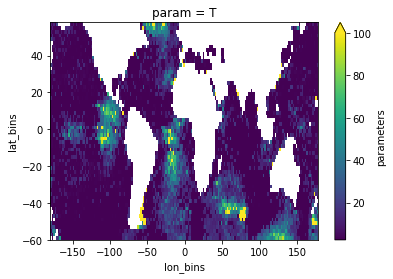

In [56]:
dsE_gauss.sel(param='T').parameters.plot(vmax=100)
plt.figure()
dsL_gauss.sel(param='T').parameters.plot(vmax=100)

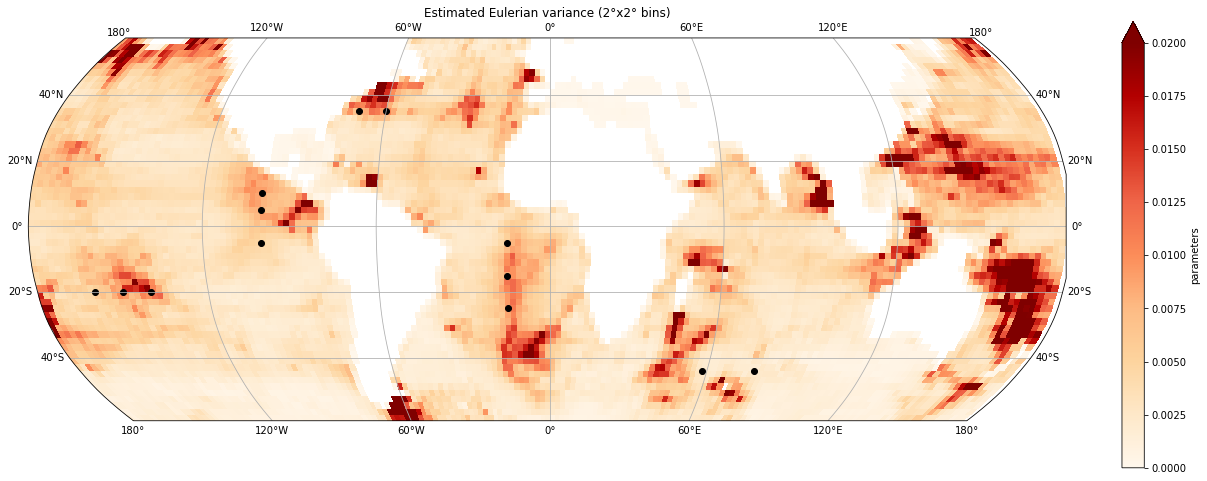

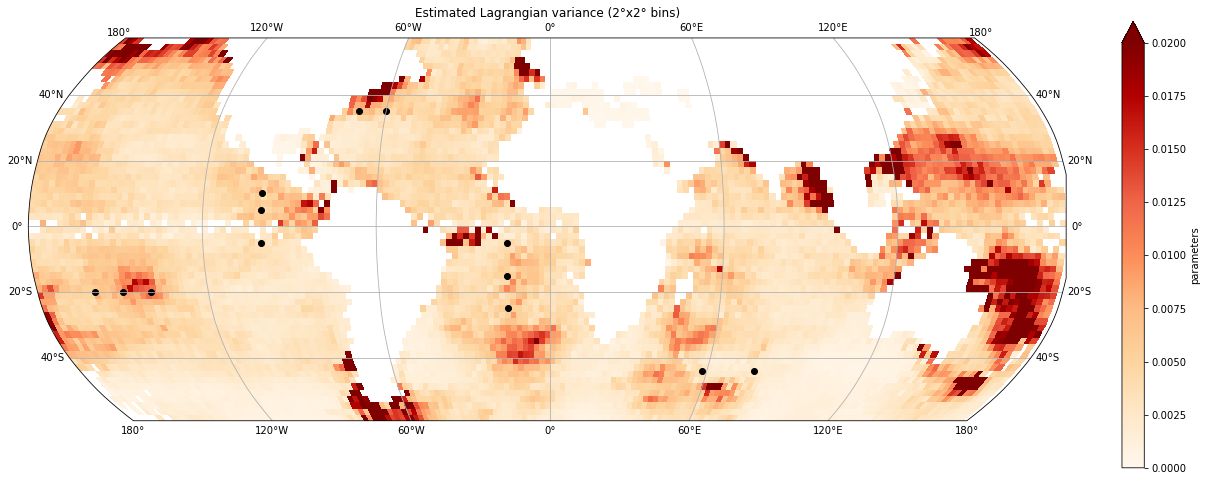

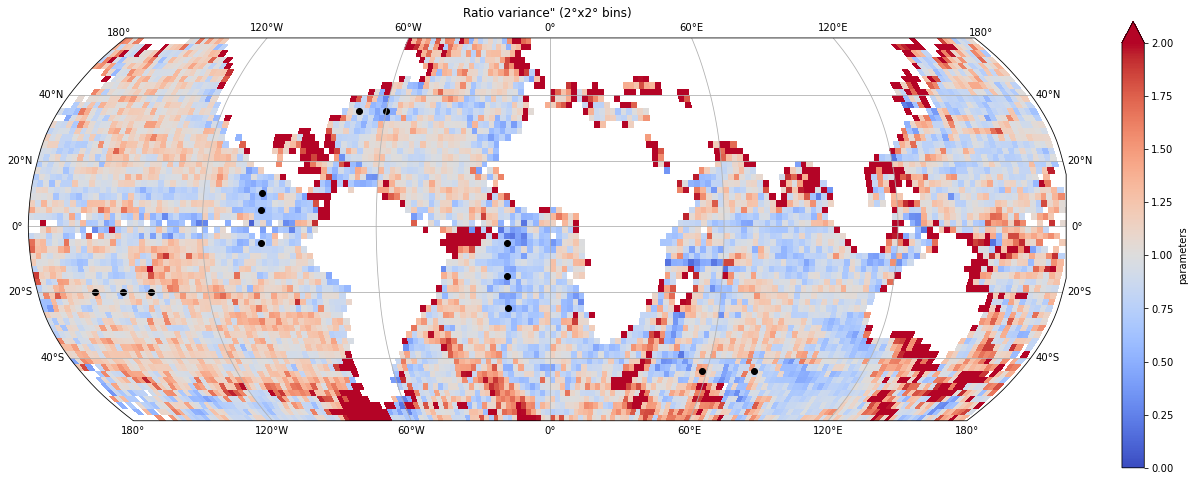

In [45]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(2*dsE_gauss.sel(param = 'V').parameters,colmap=cmap,vlim=(0,0.02))
ax.set_title('Estimated Eulerian variance (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(2*dsL_gauss.sel(param = 'V').parameters,colmap=cmap,vlim=(0,0.02))
ax.set_title('Estimated Lagrangian variance (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')
        
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_gauss/dsE_gauss).sel(param = 'V').parameters,colmap='coolwarm',vlim=(0,2))
ax.set_title('Ratio variance" (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='k')

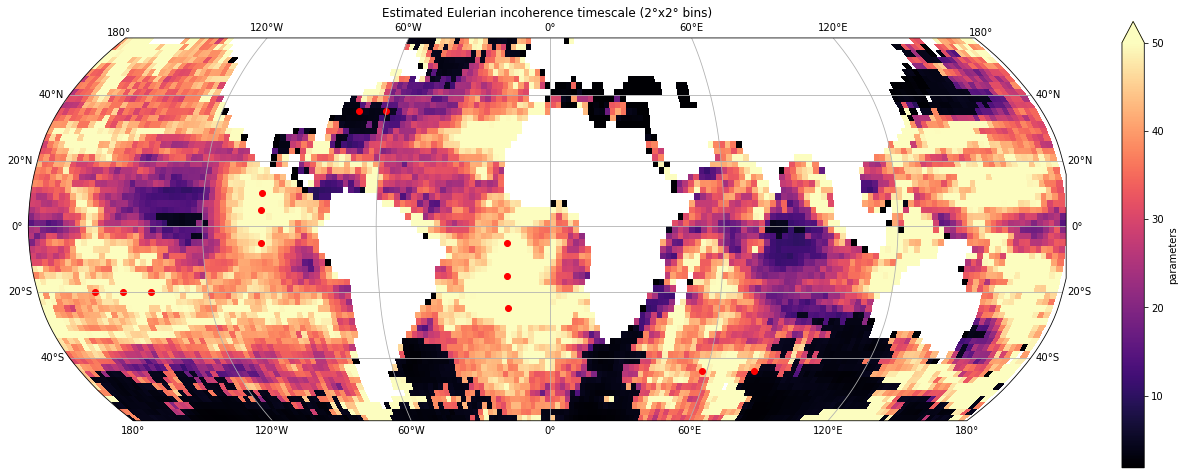

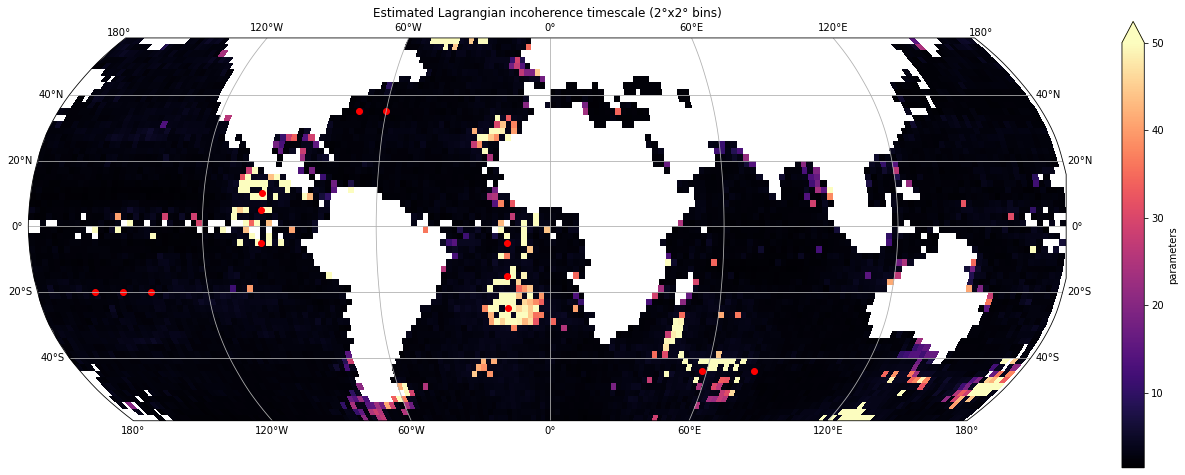

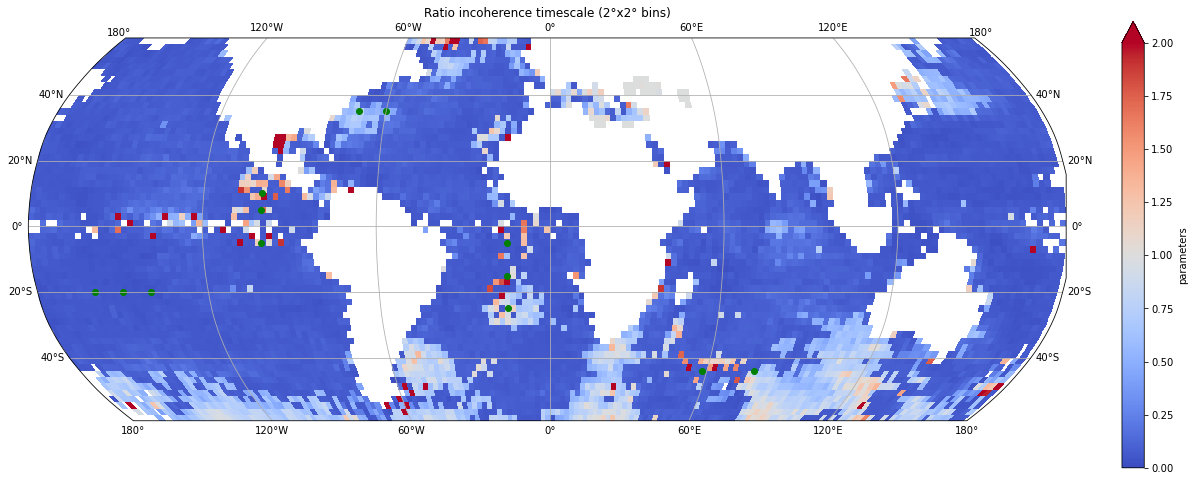

In [46]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_gauss.sel(param = 'T').parameters,colmap='magma',vlim=(None,50))
ax.set_title('Estimated Eulerian incoherence timescale (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='r')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_gauss.sel(param = 'T').parameters,colmap='magma',vlim=(None,50))
ax.set_title('Estimated Lagrangian incoherence timescale (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='r')
        
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_gauss/dsE_gauss).sel(param = 'T').parameters,colmap='coolwarm',vlim=(0,2))
ax.set_title('Ratio incoherence timescale (2°x2° bins)')
for k in areas.keys():
    for pt in areas[k]:
        ax.scatter(pt[0],pt[1],transform=ccrs.PlateCarree(),c='g')
        

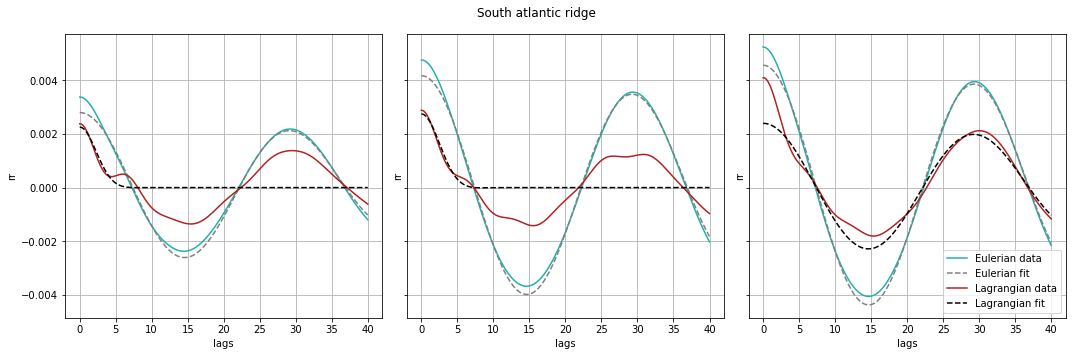

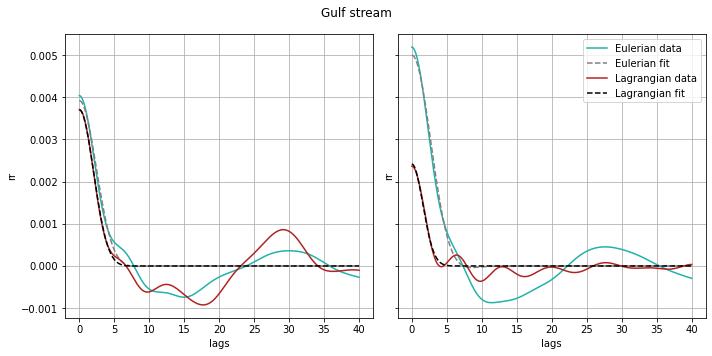

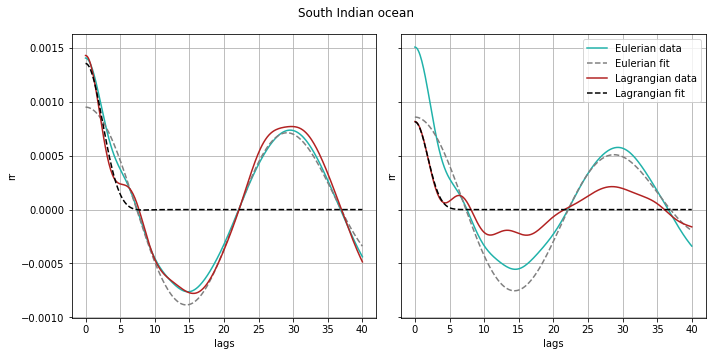

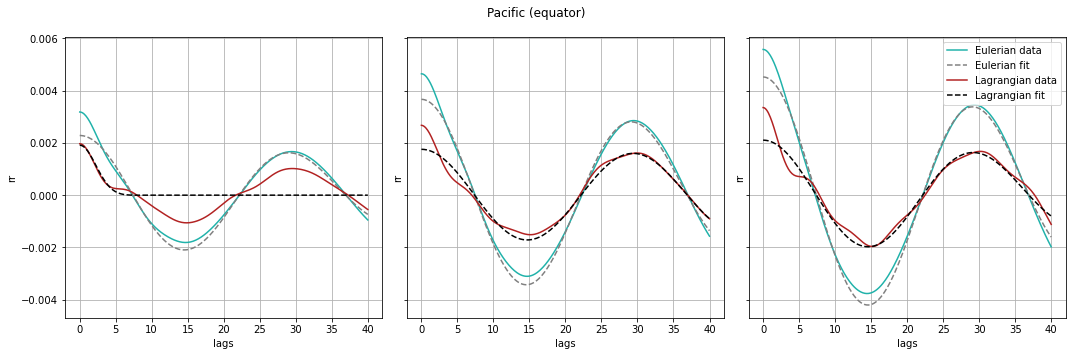

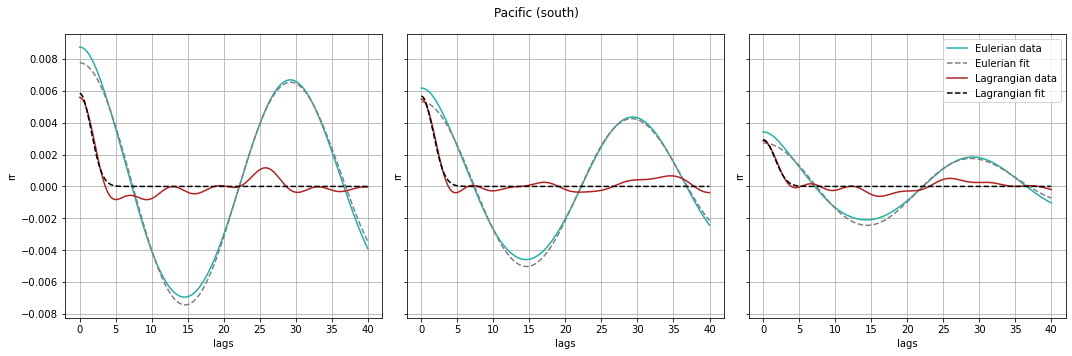

In [47]:
for k in areas.keys():
    fig,axs = plt.subplots(1,len(areas[k]),figsize=(5*len(areas[k]),5),sharey=True)
    for ax,pt in zip(axs,areas[k]):
        dsE.rr.sel(lat_bins=pt[1],lon_bins=pt[0],method='nearest').plot(ax=ax,c='lightseagreen',label='Eulerian data');
        dsE_gauss.rr.sel(lat_bins=pt[1],lon_bins=pt[0],method='nearest').plot(ax=ax,c='grey',linestyle='--',label='Eulerian fit');
        dsL.rr.sel(lat_bins=pt[1],lon_bins=pt[0],method='nearest').plot(ax=ax,c='firebrick',label='Lagrangian data');
        dsL_gauss.rr.sel(lat_bins=pt[1],lon_bins=pt[0],method='nearest').plot(ax=ax,c='k',linestyle='--',label='Lagrangian fit');
        ax.grid();ax.set_title('');
        low_var = dsE_low.rr.sel(lat_bins=pt[1],lon_bins=pt[0],method='nearest').isel(lags=0).values
#        ax.text(0,-0.004,r'$\overline{V}^2 \sim%s$'%np.around(low_var,decimals=4))
    ax.legend()
    fig.suptitle(k);fig.tight_layout();

#### Annexe

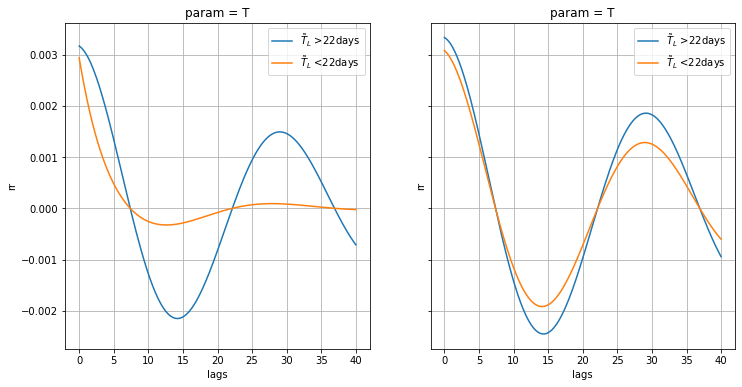

In [36]:
fig,axs=plt.subplots(1,2,figsize=(12,6),sharey=True)
dsL_out.where(dsL_out.sel(param='T').parameters>22
             ).sel(param='T').rr.mean(['lon_bins','lat_bins']).plot(ax=axs[0],label=r'$\tilde T_L$ >22days')
dsL_out.where(dsL_out.sel(param='T').parameters<22
             ).sel(param='T').rr.mean(['lon_bins','lat_bins']).plot(ax=axs[0],label=r'$\tilde T_L$ <22days')
axs[0].grid();axs[0].legend();
dsE_out.where(dsL_out.sel(param='T').parameters>22
             ).sel(param='T').rr.mean(['lon_bins','lat_bins']).plot(ax=axs[1],label=r'$\tilde T_L$ >22days')
dsE_out.where(dsL_out.sel(param='T').parameters<22
             ).sel(param='T').rr.mean(['lon_bins','lat_bins']).plot(ax=axs[1],label=r'$\tilde T_L$ <22days')
axs[1].grid();axs[1].legend();

In [37]:
Te = dsE_out.sel(param='T').parameters
Tl = dsL_out.sel(param='T').parameters

Text(0.5, 1.0, '$\\tilde T_E$')

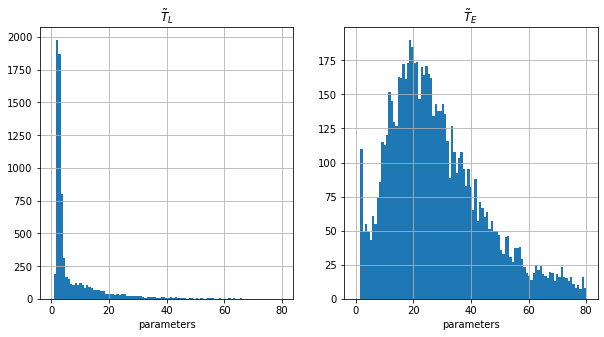

In [41]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
_ = Tl.plot.hist(bins=np.linspace(0,80,100),ax=axs[0])
axs[0].grid();axs[0].set_title(r'$\tilde T_L$')
_ = Te.plot.hist(ax=axs[1],bins=np.linspace(0,80,100));
axs[1].grid();axs[1].set_title(r'$\tilde T_E$')

In [42]:
import seaborn as sns

In [43]:
dsT = xr.merge([dsE_out.sel(param='T').parameters.rename('Te'),dsL_out.sel(param='T').parameters.rename('Tl')])

In [45]:
low_dl2 = xr.open_dataset(root_path+'variance_SSU_binned_dl2.0.nc').rename({'lon_bin':'lon_bins','lat_bin':'lat_bins'})

In [46]:
Ubar = low_dl2.L_variance_SSU
k = 2*np.pi/100*1e-3


In [47]:
dsT['kU'] = np.sqrt(Ubar)*k

In [31]:
dsT['Tbar'] = dsE_low_out.sel(param='T').parameters.rename('Tbar')
day2sec = 3600*24

Text(0.5, 1.0, 'ratio, $\\tilde T_L/\\tilde T_E$')

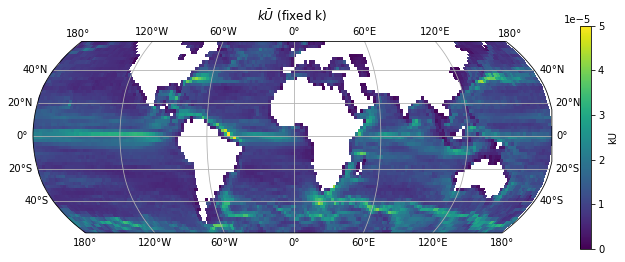

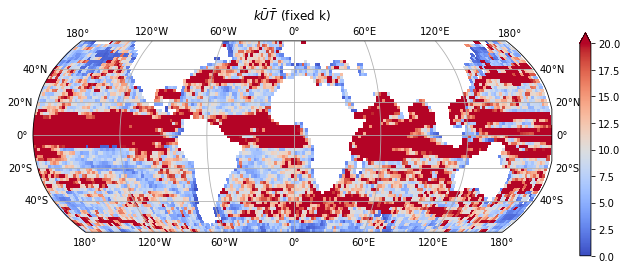

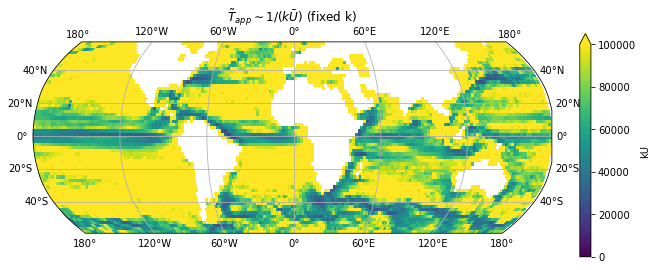

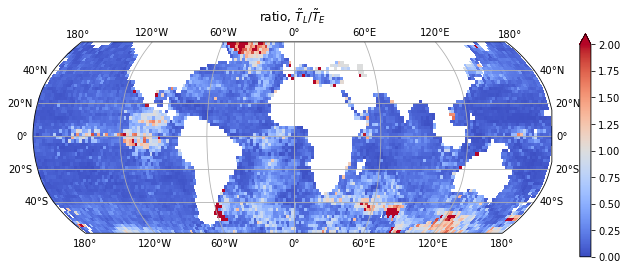

In [26]:
fig = plt.figure(figsize=(10,10))
fig,ax = plot_maps(dsT.kU,colmap='viridis',vlim=(0,5e-5))
ax.set_title(r'$k\bar U$ (fixed k)')

fig = plt.figure(figsize=(10,10))
fig,ax = plot_maps(dsT.kU*dsT.Tbar*day2sec,colmap='coolwarm',vlim=(0,20))
ax.set_title(r'$k\bar U \bar T$ (fixed k)')

fig = plt.figure(figsize=(10,10))
fig,ax = plot_maps(1/dsT.kU,colmap='viridis',vlim=(0,1e5))
ax.set_title(r'$\tilde T_{app}\sim 1/(k\bar U)$ (fixed k)')

fig = plt.figure(figsize=(10,10))
fig,ax = plot_maps(dsT.Tl/dsT.Te,colmap='coolwarm',vlim=(0,2))
ax.set_title(r'ratio, $\tilde T_L/\tilde T_E$')